In [1]:
import os
import datetime
import gzip
import json
import math
import csv
import calendar
import ipaddress
import base64
import binascii
import statistics
import time

import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
import matplotlib
import requests

import pyarrow

import matplotlib.ticker as ticker
import matplotlib.cm as pltcm
import matplotlib.colors as pltcolors

from collections import defaultdict
from datetime import datetime, timedelta
from dateutil import relativedelta
from glob import glob
from matplotlib.colors import LogNorm
from matplotlib.lines import Line2D
from tqdm import tqdm

from pathlib import Path

# -- some jupyter config ---

%matplotlib inline
%config InlineBackend.figure_format = "retina"

pl.Config.set_fmt_str_lengths(100)


polars.config.Config

In [2]:
plt.rc("figure", figsize=(8 * 0.7, 3 * 0.7))
plt.rc("figure", figsize=(8 * 0.7, 3 * 0.5))
plt.rc("font", size=12)

colors = ["#375E97", "#FB6542", "#c1195c", "#37975e"]
markers = [".", "1", "x", "+", "2", "3", "4", "^", "v", "s", "D"]
more_colors = [
    "#66C2A5",  # Soft Teal
    "#FC8D62",  # Salmon
    "#8DA0CB",  # Dusty Blue
    "#E78AC3",  # Pink Orchid
    "#A6D854",  # Lime Green
    "#FFD92F",  # Bright Pastel Yellow
    "#E5C494",  # Sandy Beige
    "#B3B3B3",  # Medium Gray
    "#A1D9CE",  # Aqua Mint
    "#F1A340",  # Warm Orange
]
tab_colors = [
    "tab:blue",
    "tab:orange",
    "tab:green",
    "tab:red",
    "tab:purple",
    "tab:brown",
    "tab:pink",
    "tab:gray",
    "tab:olive",
    "tab:cyan"
]
may_colors = ['#a6cee3','#1f78b4','#b2df8a',
          '#33a02c','#fb9a99','#e31a1c',
          '#fdbf6f','#ff7f00','#9e9ac8',
          '#3f007d','#a6cee3','#b15928',
         '#e0ecf4','#f7fcb9','#c994c7',
          '#006d2c','#e6550d','#810f7c']

chatgpt_colors = [
    # "#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
    # "#911eb4", "#46f0f0", "#f032e6", "#d2f53c", "#fabebe", "#e6194b", "#3cb44b", "#ffe119", "#0082c8", "#f58231",
    "#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00", "#ffff33", "#a65628", "#f781bf", "#999999", "#66c2a5"
]

tab_colors = [
    "tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"
]

start_date=datetime(2023, 8, 24)
end_date=datetime(2024,7,2)

## Scanner Overlap

F-Comment-4:
>Explore Scanner Overlap in More Detail: The observed low overlap between scanners is considered interesting by several reviewers but is not thoroughly discussed in the current version. A dedicated analysis and discussion would help to understand the implications and relevance of this result.
    
B-Comment-1:
>The first surprise is that the overlap of the scanners between the different telescopes is apparently minimal. This reviewer does not consider it an overlap if two scanners are located in the same AS.

## Action Items

* Characteristics of overlapping addresses
* Timeline: When do addresses overlap?
* What is the AS type of overlapping sources?
* prefix aggregation?
* two perspectives:
    i) why is the overlap low (e.g., different scan sources belong to the same scanning campaign)?
    ii) what do we learn for the low-overlapping scanners?


### Preparation

In [3]:
datafolder = Path("/net/archive/telescope/dataframe")
dataframes_default = [
    "/net/archive/telescope/dataframe/telescope-t1-20240702.parquet",
    "/net/archive/telescope/dataframe/telescope-t2-20240702.parquet",
    "/net/archive/telescope/dataframe/telescope-t3-20240702.parquet",
    "/net/archive/telescope/dataframe/telescope-t4-20240702.parquet",
]

dataframes_with_spoki = [
    "/net/archive/telescope/dataframe/telescope-t2-20240702-withSpoki.parquet",
    "/net/archive/telescope/dataframe/telescope-t4-20240702-withSpoki.parquet",
]

dataframes_other = [
    "/net/archive/telescope/dataframe/telescope-t2-20240702-noDNS-noSpoki.parquet",
]

dataframes = dataframes_default

In [4]:
announcement_log_file = f'/net/archive/telescope/dataframe/prefix-announcements.csv'
announcement_df = pd.read_csv(announcement_log_file)
vertical_dates = [datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in announcement_df[1:].Timestamp_From.unique()]

In [5]:
def query_pdb(asn, api_key):
    url = "https://www.peeringdb.com/api/net?asn=" + str(asn)
    headers = {
        "Authorization": "Api-Key " + api_key,
    }
    r = requests.get(url, headers=headers)
    try:
        return r.json()["data"][0]["info_type"]
    except IndexError:
        return None
    except KeyError as ke:
        print(f"Key error for key {asn}: '{ke}'")
        print(f"ERR: {r.json()}")
        return None

PEERINGDB_API_KEY = "SFEE21aL.lRILA8tFiILdvoBFBiegiXjM9KoG4KDy"

### Load data

In [6]:
with pl.StringCache():
    dfs = [pl.read_parquet(fn, use_pyarrow=True) for fn in dataframes]

In [7]:
dft1 = dfs[0]
dft2 = dfs[1]
dft3 = dfs[2]
dft4 = dfs[3]

In [8]:
dft1

Timestamp,Frame_Length,IP_Version,Flow_Label,Payload_Length,Next_Header,Hop_Limit,Source_Address,Destination_Address,Protocol,UDP_src_port,UDP_dst_port,TCP_src_port,TCP_dst_port,TCP_payload,TCP_seq,TCP_ack,TCP_Flags,QUIC_version,ICMPv6_Type,Payload,Payload_Text,Payload_ByteLength,DNS_id,DNS_qry_name,DNS_resp_flag,Date,Hour,Minute,MostSpecificPrefix,scantool,scan_source_128,fullhex_destination_address,scan_source_32,scan_source_48,scan_source_64,Announcement_Period,Geo,AS-Number,prefix_target,Org,Announcement_Timestamp,announcement_reaction_time,Interarrival_Time_128,Session_ID_128,Interarrival_Time_64,Session_ID_64,Interarrival_Time_48,Session_ID_48,is_oneoff_128,is_oneoff_64,is_oneoff_48,is_triggered_128,is_triggered_64,is_triggered_48,period_128,dest_addr_type,scan_behavior_128,__index_level_0__
datetime[ns],u16,u8,cat,i32,u8,u8,cat,str,cat,u16,u16,u16,u16,str,u64,f64,cat,f64,f64,str,f64,i32,cat,str,u8,datetime[ns],u8,u8,cat,cat,cat,str,cat,cat,cat,u8,cat,i32,cat,cat,datetime[ns],duration[ns],duration[ns],u32,duration[ns],u32,duration[ns],u32,bool,bool,bool,bool,bool,bool,f64,str,cat,i64
2023-08-24 08:29:07.513005587,78,6,"""0x00000000""",24,6,1,"""2a05:e740:4162::2""","""2a05:e747:5fd0:b177:4c4:8453:6725:a2a3""","""TCP""",null,null,49152,80,"""nan""",116744,1.6929e9,"""··········S·""",null,null,"""nan""",null,null,"""nan""","""nan""",null,2023-08-24 00:00:00,8,8,"""2a05:e747::/33""","""Other""","""2a05e740416200000000000000000002""","""2a05e7475fd0b17704c484536725a2a3""","""2a05e740""","""2a05e7404162""","""2a05e74041620000""",0,"""DE""",29108,"""2a05:e740:4162::/48""","""LEITWERT-RESEARCH""",2023-08-24 00:00:00,8h 29m 7s 513005587ns,null,78841,null,77390,null,76736,false,false,false,true,true,true,1440.0,"""randomized""","""independent""",0
2023-08-24 08:29:07.555091200,78,6,"""0x00000000""",24,6,2,"""2a05:e740:4162::2""","""2a05:e747:5fd0:b177:4c4:8453:6725:a2a3""","""TCP""",null,null,49152,80,"""nan""",116746,1.6929e9,"""··········S·""",null,null,"""nan""",null,null,"""nan""","""nan""",null,2023-08-24 00:00:00,8,8,"""2a05:e747::/33""","""Other""","""2a05e740416200000000000000000002""","""2a05e7475fd0b17704c484536725a2a3""","""2a05e740""","""2a05e7404162""","""2a05e74041620000""",0,"""DE""",29108,"""2a05:e740:4162::/48""","""LEITWERT-RESEARCH""",2023-08-24 00:00:00,8h 29m 7s 555091200ns,42085613ns,78841,42085613ns,77390,42085613ns,76736,false,false,false,true,true,true,1440.0,"""randomized""","""independent""",1
2023-08-24 08:29:07.596888948,78,6,"""0x00000000""",24,6,3,"""2a05:e740:4162::2""","""2a05:e747:5fd0:b177:4c4:8453:6725:a2a3""","""TCP""",null,null,49152,80,"""nan""",116748,1.6929e9,"""··········S·""",null,null,"""nan""",null,null,"""nan""","""nan""",null,2023-08-24 00:00:00,8,8,"""2a05:e747::/33""","""Other""","""2a05e740416200000000000000000002""","""2a05e7475fd0b17704c484536725a2a3""","""2a05e740""","""2a05e7404162""","""2a05e74041620000""",0,"""DE""",29108,"""2a05:e740:4162::/48""","""LEITWERT-RESEARCH""",2023-08-24 00:00:00,8h 29m 7s 596888948ns,41797748ns,78841,41797748ns,77390,41797748ns,76736,false,false,false,true,true,true,1440.0,"""randomized""","""independent""",2
2023-08-24 08:29:07.638593556,78,6,"""0x00000000""",24,6,4,"""2a05:e740:4162::2""","""2a05:e747:5fd0:b177:4c4:8453:6725:a2a3""","""TCP""",null,null,49152,80,"""nan""",116750,1.6929e9,"""··········S·""",null,null,"""nan""",null,null,"""nan""","""nan""",null,2023-08-24 00:00:00,8,8,"""2a05:e747::/33""","""Other""","""2a05e740416200000000000000000002""","""2a05e7475fd0b17704c484536725a2a3""","""2a05e740""","""2a05e7404162""","""2a05e74041620000""",0,"""DE""",29108,"""2a05:e740:4162::/48""","""LEITWERT-RESEARCH""",2023-08-24 00:00:00,8h 29m 7s 638593556ns,41704608ns,78841,41704608ns,77390,41704608ns,76736,false,false,false,true,true,true,1440.0,"""randomized""","""independent""",3
2023-08-24 08:29:07.680545820,78,6,"""0x00000000""",24,6,5,"""2a05:e740:4162::2""","""2a05:e747:5fd0:b177:4c4:8453:6725:a2a3""","""TCP""",null,null,49152,80,"""nan""",

In [8]:
dft1["Destination_Address"].n_unique() / (2**(128-32)) * 100

4.595536213962399e-20

In [31]:
addrs = set(dft1["Destination_Address"])
prefixes_64 = set([ipaddress.IPv6Address(addr).exploded[:19] for addr in tqdm(addrs)])

100%|██████████| 36409589/36409589 [10:34<00:00, 57416.65it/s]


In [27]:
print(ipaddress.IPv6Address("2a05:e747:2012::3").exploded)
print(ipaddress.IPv6Address("2a05:e747:2012::3").exploded[:19])

2a05:e747:2012:0000:0000:0000:0000:0003
2a05:e747:2012:0000


In [32]:
print(len(addrs), "of", (2**(128-32)), "=", len(addrs) / (2**(128-32)) * 100)
print(len(prefixes_64), "of", (2**32), "=", len(prefixes_64) / (2**32) * 100)

36409589 of 79228162514264337593543950336 = 4.595536213962399e-20
24918330 of 4294967296 = 0.5801750812679529


### Overlapping Addresses

Let's start with overlapping addresses.

Preparation:

1. Build an address set for each telescope.
2. Build the respective overlap sets.

Analysis 1: Address characterists, i.e., scanner behavior, network types?

Analysis 2: How do these addresses aggregate? (/64, /32, etc.)

Analysis 3: PLOT: Timeline to examine when these events appear.

Analysis 4 i) why is the overlap low (e.g., different scan sources belong to the same scanning campaign)?

Analysis 4 ii) what do we learn for the low-overlapping scanners?

#### Addresses

In [9]:
addrs_t1 = set(pl.Series(dft1.select(pl.col("Source_Address"))).unique().to_list())
addrs_t2 = set(pl.Series(dft2.select(pl.col("Source_Address"))).unique().to_list())
addrs_t3 = set(pl.Series(dft3.select(pl.col("Source_Address"))).unique().to_list())
addrs_t4 = set(pl.Series(dft4.select(pl.col("Source_Address"))).unique().to_list())

In [10]:
t1_t2 = addrs_t1.intersection(addrs_t2)
t1_t3 = addrs_t1.intersection(addrs_t3)
t1_t4 = addrs_t1.intersection(addrs_t4)

t2_t1 = t1_t2
t2_t3 = addrs_t2.intersection(addrs_t3)
t2_t4 = addrs_t2.intersection(addrs_t4)

t3_t1 = t1_t3
t3_t2 = t2_t3
t3_t4 = addrs_t3.intersection(addrs_t4)

t4_t1 = t1_t4
t4_t2 = t2_t4
t4_t3 = t3_t4

seen_by_all = addrs_t1.intersection(addrs_t2).intersection(addrs_t3).intersection(addrs_t4)

In [11]:
print("t1 and t2 saw", len(t1_t2), "shared addresses")
print("t1 and t3 saw", len(t1_t3), "shared addresses")
print("t1 and t4 saw", len(t1_t4), "shared addresses")

print("t2 and t1 saw", len(t2_t1), "shared addresses")
print("t2 and t3 saw", len(t2_t3), "shared addresses")
print("t2 and t4 saw", len(t2_t4), "shared addresses")

print("t3 and t1 saw", len(t3_t1), "shared addresses")
print("t3 and t2 saw", len(t3_t2), "shared addresses")
print("t3 and t4 saw", len(t3_t4), "shared addresses")

print("t4 and t1 saw", len(t4_t1), "shared addresses")
print("t4 and t2 saw", len(t4_t2), "shared addresses")
print("t4 and t3 saw", len(t4_t3), "shared addresses")

print("overlap saw", len(seen_by_all), "shared addresses")

t1 and t2 saw 2169 shared addresses
t1 and t3 saw 15 shared addresses
t1 and t4 saw 36 shared addresses
t2 and t1 saw 2169 shared addresses
t2 and t3 saw 18 shared addresses
t2 and t4 saw 31 shared addresses
t3 and t1 saw 15 shared addresses
t3 and t2 saw 18 shared addresses
t3 and t4 saw 10 shared addresses
t4 and t1 saw 36 shared addresses
t4 and t2 saw 31 shared addresses
t4 and t3 saw 10 shared addresses
overlap saw 10 shared addresses


In [12]:
seen_by_all

{'2001:253:ff:4301:3673:79ff:fe91:48b8',
 '2001:550:9005:1000::11',
 '2001:550:9005:2000::11',
 '2001:da8:bf:300:ae1f:6bff:fefb:8b62',
 '2401:c080:1c00:2d8c:5400:4ff:feb3:fd43',
 '2401:c080:1c02:d91:5400:4ff:feaa:f563',
 '2602:ffd5:1:164::1',
 '2605:6400:10:6a8:bc7a:408:1ad:e7e6',
 '2a01:190:151a:1::5ba:100',
 '2a01:190:151a::5ba:100'}

#### ASNs

In [13]:
asn_t1 = set(pl.Series(dft1.select(pl.col("AS-Number"))).unique().to_list())
asn_t2 = set(pl.Series(dft2.select(pl.col("AS-Number"))).unique().to_list())
asn_t3 = set(pl.Series(dft3.select(pl.col("AS-Number"))).unique().to_list())
asn_t4 = set(pl.Series(dft4.select(pl.col("AS-Number"))).unique().to_list())
all_asn_numbers = asn_t1.union(asn_t2).union(asn_t3).union(asn_t4)

In [14]:
asn_t1_t2 = asn_t1.intersection(asn_t2)
asn_t1_t3 = asn_t1.intersection(asn_t3)
asn_t1_t4 = asn_t1.intersection(asn_t4)

asn_t2_t1 = t1_t2
asn_t2_t3 = asn_t2.intersection(asn_t3)
asn_t2_t4 = asn_t2.intersection(asn_t4)

asn_t3_t1 = t1_t3
asn_t3_t2 = t2_t3
asn_t3_t4 = asn_t3.intersection(asn_t4)

asn_t4_t1 = t1_t4
asn_t4_t2 = t2_t4
asn_t4_t3 = t3_t4

asn_seen_by_all = asn_t1.intersection(asn_t2).intersection(asn_t3).intersection(asn_t4)

In [15]:

# { asn: query_pdb(asn, PEERINGDB_API_KEY) for asn in all_asn_numbers }
asn_to_pdb = {}

pdb_fn = "asn-pdb-types.txt"

if Path(pdb_fn).exists():
    print("reading existing file")
    with open(pdb_fn, "r") as fh:
        for line in fh:
            k, v = line.strip().split('|')
            if k != "None":
                asn_to_pdb[int(k)] = v
else:
    API_LIMIT = 20

    window_start = datetime.now()
    window_requested = 0

    for asn in tqdm(all_asn_numbers):
        res = query_pdb(asn, PEERINGDB_API_KEY)
        asn_to_pdb[asn] = res
        current_time = datetime.now()
        if current_time - window_start >= timedelta(minutes=1):
            window_start = current_time
            window_requested = 1
        else:
            window_requested += 1
            if window_requested >= API_LIMIT:
                target = window_start + timedelta(minutes=1)
                delta = (target - current_time).total_seconds()
                # print(f"sleeping for {delta} seconds")
                time.sleep(delta)
                window_start = datetime.now()
                window_requested = 1

    # Write to disk.

    with open(pdb_fn, "w") as fh:
        for k, v in asn_to_pdb.items():
            if v is None or v == "":
                fh.write(f"{k}|None\n")
            else:
                fh.write(f"{k}|{v}\n")



reading existing file


Let's start with those seen at every telescope.

#### Characteristics

- behavior
- network types

In [16]:
def filter_all(df, filter_set):
    return df.filter(pl.col("Source_Address").is_in(filter_set))


subset_t1 = filter_all(dft1, seen_by_all)
subset_t2 = filter_all(dft2, seen_by_all)
subset_t3 = filter_all(dft3, seen_by_all)
subset_t4 = filter_all(dft4, seen_by_all)

In [17]:
# ['Timestamp', 'Frame_Length', 'IP_Version', 'Flow_Label', 'Payload_Length', 'Next_Header', 'Hop_Limit', 'Source_Address', 'Destination_Address', 'Protocol', 'UDP_src_port', 'UDP_dst_port', 'TCP_src_port', 'TCP_dst_port', 'TCP_payload', 'TCP_seq', 'TCP_ack', 'TCP_Flags', 'QUIC_version', 'ICMPv6_Type', 'Payload', 'Payload_Text', 'Payload_ByteLength', 'DNS_id', 'DNS_qry_name', 'DNS_resp_flag', 'Date', 'Hour', 'Minute', 'MostSpecificPrefix', 'scantool', 'scan_source_128', 'fullhex_destination_address', 'scan_source_32', 'scan_source_48', 'scan_source_64', 'Announcement_Period', 'Geo', 'AS-Number', 'prefix_target', 'Org', 'Announcement_Timestamp', 'announcement_reaction_time', 'Interarrival_Time_128', 'Session_ID_128', 'Interarrival_Time_64', 'Session_ID_64', 'Interarrival_Time_48', 'Session_ID_48', 'is_oneoff_128', 'is_oneoff_64', 'is_oneoff_48', 'is_triggered_128', 'is_triggered_64', 'is_triggered_48', 'period_128', 'dest_addr_type', 'scan_behavior_128', '__index_level_0__']

In [18]:
def count_by(column):
    return subset_t1.group_by(pl.col(column)).agg(
        pl.col("Source_Address").count().alias("T1")
    ).join(subset_t2.group_by(pl.col(column)).agg(
        pl.col("Source_Address").count().alias("T2")
    ), on=column, how="full", coalesce=True).join(subset_t3.group_by(pl.col(column)).agg(
        pl.col("Source_Address").count().alias("T3")
    ), on=column, how="full", coalesce=True).join(subset_t4.group_by(pl.col(column)).agg(
        pl.col("Source_Address").count().alias("T4")
    ), on=column, how="full", coalesce=True)

count_by("Protocol")

Protocol,T1,T2,T3,T4
cat,u32,u32,u32,u32
"""ICMPv6""",10585034,207656,17,17
"""DNS""",9994851,134458,14,76
"""SSL""",null,8192,null,null
"""TCP""",68,31434,720,44
"""UDP""",51,3,null,null


In [19]:
count_by("Geo")

Geo,T1,T2,T3,T4
cat,u32,u32,u32,u32
"""CN""",9390146,201457,4,11
"""US""",9639201,105644,731,70
"""KR""",224107,5379,2,43
"""AT""",1114918,65331,10,10
"""CA""",211632,3932,4,3


In [20]:
count_by("TCP_dst_port")

TCP_dst_port,T1,T2,T3,T4
u16,u32,u32,u32,u32
null,null,342117,null,null
443,40,19879,368,22
80,28,19747,352,22
null,20579936,null,null,null
null,null,null,31,null
null,null,null,null,93


In [21]:
count_by("UDP_dst_port")

UDP_dst_port,T1,T2,T3,T4
u16,u32,u32,u32,u32
null,10585102,null,null,null
33435,34,null,null,null
33444,17,null,null,null
53,9994851,134458,14,76
null,null,247282,null,null
33443,null,3,null,null
null,null,null,737,null
null,null,null,null,61


In [22]:
count_by("scantool")

scantool,T1,T2,T3,T4
cat,u32,u32,u32,u32
"""6Seek""",30930,2244,1,null
"""Other""",19431568,377606,740,127
"""RIPEAtlasProbe""",2588,669,null,null
"""Yarrp6""",1114918,1223,10,10
"""6Scan""",null,1,null,null


In [23]:
count_by("dest_addr_type")

dest_addr_type,T1,T2,T3,T4
str,u32,u32,u32,u32
"""full_zero_addr""",2,1543,null,null
"""low-byte""",2706,26494,676,10
"""randomized""",20577001,340742,31,91
"""ieee-derived""",215,7,null,null
"""embedded-ipv4""",null,12735,null,36
"""embedded-port""",null,112,44,null
"""pattern-bytes""",80,110,null,null


#### Timeline

In [24]:

def make_overlap_plot(filter_set, min_date=None, max_date=None, title=None, color=None, ax=None, figsize=None):

    def filter_all(df, name):
        return df.filter(pl.col("Source_Address").is_in(filter_set)).select(
            pl.col("Timestamp"),
            pl.col("Source_Address"),
            pl.col("Protocol"),
        ).with_columns(
            pl.col("Timestamp").dt.date().alias("Date"),
        ).group_by([pl.col("Date")]).agg(
            pl.col("Source_Address").count().alias(name)
        )


    overlap_t1 = filter_all(dft1, "T1")
    overlap_t2 = filter_all(dft2, "T2")
    overlap_t3 = filter_all(dft3, "T3")
    overlap_t4 = filter_all(dft4, "T4")
    sum_t1 = overlap_t1["T1"].sum()
    sum_t2 = overlap_t2["T2"].sum()
    sum_t3 = overlap_t3["T3"].sum()
    sum_t4 = overlap_t4["T4"].sum()
    total = sum_t1 + sum_t2 + sum_t3 + sum_t4
    print(f"{sum_t1}|{sum_t2}|{sum_t3}|{sum_t4}")
    print(f"{round( 100 * sum_t1 / total, 1)}|{round( 100 * sum_t2 / total, 1)}|{round( 100 * sum_t3 / total, 1)}|{round( 100 * sum_t4 / total, 1)}")

    # Create one df

    overlap_df = overlap_t1.join(overlap_t2, on="Date", how="full", coalesce=True)
    overlap_df = overlap_df.join(overlap_t3, on="Date", how="full", coalesce=True)
    overlap_df = overlap_df.join(overlap_t4, on="Date", how="full", coalesce=True)
    overlap_df

    # Turn to pandas and reindex.
    plot_df = overlap_df.sort(pl.col("Date")).to_pandas()

    # Reindes timerange.
    if min_date is None:
        min_date = plot_df["Date"].min() - timedelta(days=3) 
    if max_date is None:
        max_date = plot_df["Date"].max() + timedelta(days=3) 
    

    minimal_distance = 40
    distance = (max_date - min_date).days
    if distance < minimal_distance:
        print(f"current distance: {distance}, increasing to {minimal_distance}")
        missing_distance = minimal_distance - distance
        min_date -= timedelta(days=int(missing_distance/2))
        max_date += timedelta(days=(missing_distance - int(missing_distance/2)))


    plot_df = plot_df.set_index("Date")
    range = pd.date_range(start=min_date, end=max_date, freq='D')
    plot_df = plot_df.reindex(index=range)
    # plot_df = plot_df.groupby(pd.Grouper(freq="1W")).agg("sum")

    # ax = sns.lineplot(plot_df)

    # Estimate how wide the picture should be.
    full_width = 8 * 0.7
    full_height = 3 * 0.5
    unit = full_width / (end_date - start_date).days
    print(f"full width: {full_width}")
    print(f"one unit is {unit}")

    delta = (max_date - min_date).days
    width = delta * unit
    print(f"delta: {delta}")
    print(f"this should be: {width}")

    if color is None:
        if figsize is None:
            ax = plot_df.plot(ax=ax, color=color, style=[".--", "1--", "x--", "+--"], figsize=(width, full_height))
        else:
            ax = plot_df.plot(ax=ax, color=color, style=[".--", "1--", "x--", "+--"], figsize=figsize)
    else:
        if figsize is None:
            ax = plot_df.plot(ax=ax, color=color, style=[".", "1", "x", "+"], legend=False, figsize=(width, full_height))
        else:
            ax = plot_df.plot(ax=ax, color=color, style=[".", "1", "x", "+"], legend=False, figsize=figsize)

    ax.set_yscale("log")

    ax.set_xlabel("Time [D]")
    ax.set_ylabel("Packets [#]")

    if title is not None:
        ax.set_title(title)

    # Make vertical lines for the announcement dates
    # for date in vertical_dates:
    #     ax.axvline(date, color="grey", linestyle="--", linewidth=1)

    return ax
    


20580004|381743|751|137
98.2|1.8|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 272
this should be: 4.866453674121405


<Axes: xlabel='Time [D]', ylabel='Packets [#]'>

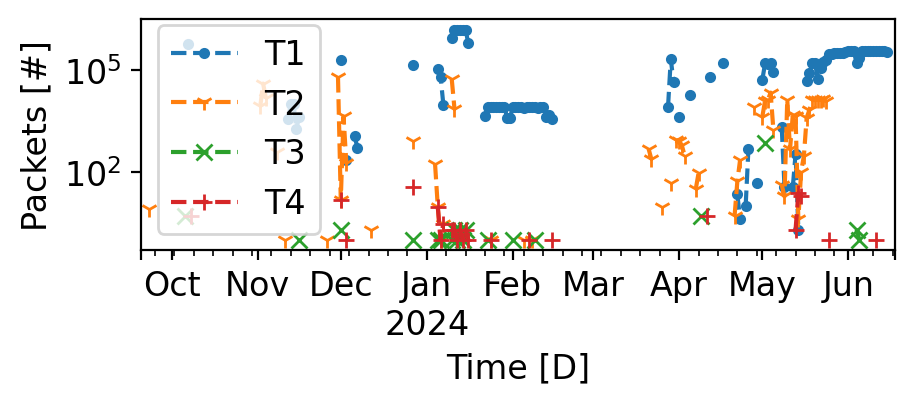

In [25]:
make_overlap_plot(filter_set=seen_by_all)

addr:  2001:253:ff:4301:3673:79ff:fe91:48b8
9254240|137224|3|2
98.5|1.5|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2a01:190:151a::5ba:100
590367|65322|5|5
90.0|10.0|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2001:da8:bf:300:ae1f:6bff:fefb:8b62
135906|64233|1|9
67.9|32.1|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2602:ffd5:1:164::1
211632|3932|4|3
98.2|1.8|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2a01:190:151a:1::5ba:100
524551|9|5|5
100.0|0.0|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2001:550:9005:1000::11
43|20245|352|24
0.2|98.0|1.7|0.1
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2001:550:9005:2000::11
75|19891|368|22
0.4|97.7|1.8|0.1
full width: 5.6
one unit is 0.01789137380191693
delta: 

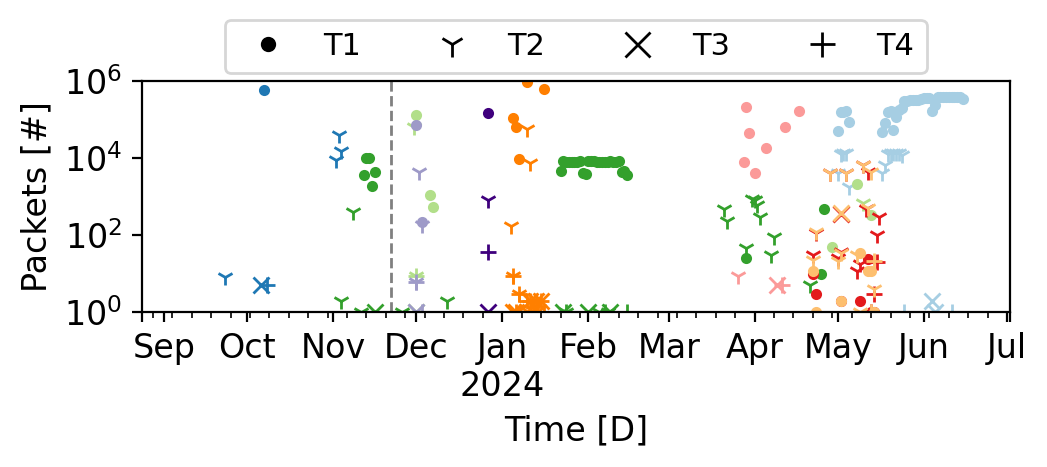

In [26]:
ax = None

for i, addr in enumerate(seen_by_all):
    print("addr: ", str(addr))
    ax = make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date, color=may_colors[i], ax=ax)
    # make_overlap_plot(filter_set=set([addr]), title=str(addr), min_date=start_date, max_date=end_date, color=tab_colors[i], ax=ax)

msize = 9
col = 'black'
mfcol = 'black'
legend_elements = [
    Line2D([0], [0], linestyle='', marker='.', color=col, label='T1', markerfacecolor=mfcol, markersize=msize),
    Line2D([0], [0], linestyle='', marker='1', color=col, label='T2', markerfacecolor=mfcol, markersize=msize),
    Line2D([0], [0], linestyle='', marker='x', color=col, label='T3', markerfacecolor=mfcol, markersize=msize),
    Line2D([0], [0], linestyle='', marker='+', color=col, label='T4', markerfacecolor=mfcol, markersize=msize),
]

ax.legend(bbox_to_anchor=(0.5, 1.15), handles=legend_elements, loc='center', ncol=4, fontsize=11)

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

ax.set_ylim([10**0, 10**6])

ax.axvline(vertical_dates[0], color="grey", linestyle="--", linewidth=1)

plt.savefig('plots/overlap-addrs-all-packets.pdf', bbox_inches='tight')


#### With Sessions

In [27]:

def make_overlap_plot_sessions(filter_set, min_date=None, max_date=None, title=None, color=None, ax=None):

    def filter_all_session(df, name):
        return df.filter(pl.col("Source_Address").is_in(filter_set)).select(
            pl.col("Timestamp"),
            pl.col("Source_Address"),
            pl.col("Protocol"),
            pl.col("Session_ID_128")
        ).with_columns(
            pl.col("Timestamp").dt.date().alias("Date"),
        ).group_by([pl.col("Date")]).agg(
            pl.col("Session_ID_128").n_unique().alias(name)
        )


    overlap_t1 = filter_all_session(dft1, "T1")
    overlap_t2 = filter_all_session(dft2, "T2")
    overlap_t3 = filter_all_session(dft3, "T3")
    overlap_t4 = filter_all_session(dft4, "T4")

    # Create one df

    overlap_df = overlap_t1.join(overlap_t2, on="Date", how="full", coalesce=True)
    overlap_df = overlap_df.join(overlap_t3, on="Date", how="full", coalesce=True)
    overlap_df = overlap_df.join(overlap_t4, on="Date", how="full", coalesce=True)
    overlap_df

    # Turn to pandas and reindex.
    plot_df = overlap_df.sort(pl.col("Date")).to_pandas()

    # Reindes timerange.
    if min_date is None:
        min_date = plot_df["Date"].min()
    if max_date is None:
        max_date = plot_df["Date"].max()
    # print(min_date, max_date)
    plot_df = plot_df.set_index("Date")
    range = pd.date_range(start=min_date, end=max_date, freq='D')
    plot_df = plot_df.reindex(index=range)

    # ax = sns.lineplot(plot_df)

    if color is None:
        ax = plot_df.plot(ax=ax, color=color, style=[".--", "1--", "x--", "+--"])
    else:
        ax = plot_df.plot(ax=ax, color=color, style=[".", "1", "x", "+"], legend=False)

    # ax.set_yscale("log")

    ax.set_xlabel("Time [D]")
    ax.set_ylabel("Sessions [#]")

    if title is not None:
        ax.set_title(title)

    # Make vertical lines for the announcement dates
    # for date in vertical_dates:
    #     ax.axvline(date, color="grey", linestyle="--", linewidth=1)

    return ax

<Axes: xlabel='Time [D]', ylabel='Sessions [#]'>

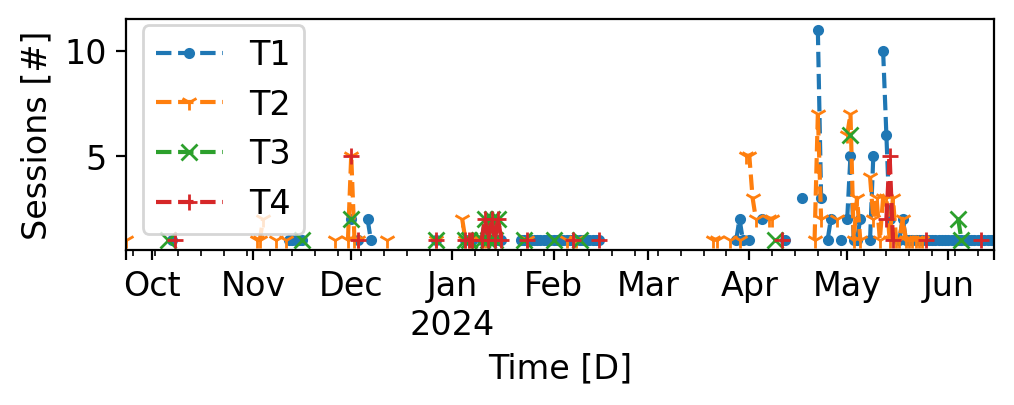

In [28]:
make_overlap_plot_sessions(filter_set=seen_by_all)

addr:  2001:253:ff:4301:3673:79ff:fe91:48b8
addr:  2a01:190:151a::5ba:100
addr:  2001:da8:bf:300:ae1f:6bff:fefb:8b62
addr:  2602:ffd5:1:164::1
addr:  2a01:190:151a:1::5ba:100
addr:  2001:550:9005:1000::11
addr:  2001:550:9005:2000::11
addr:  2605:6400:10:6a8:bc7a:408:1ad:e7e6
addr:  2401:c080:1c02:d91:5400:4ff:feaa:f563
addr:  2401:c080:1c00:2d8c:5400:4ff:feb3:fd43


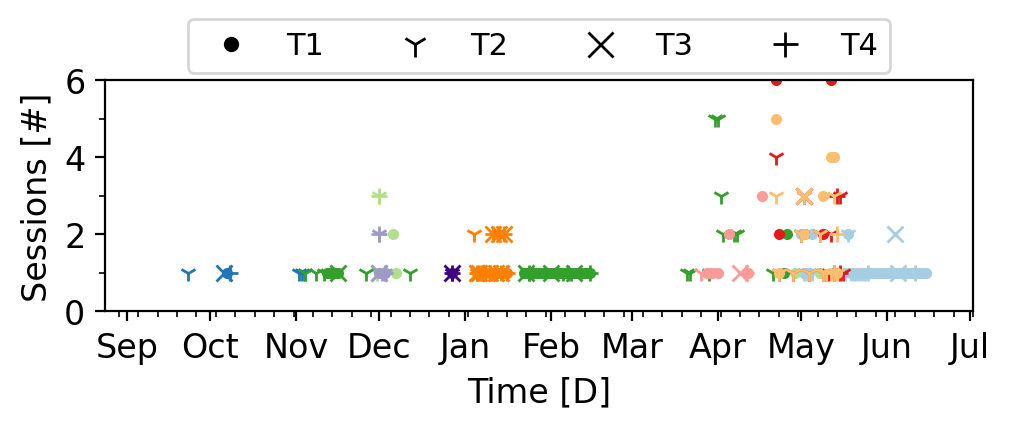

In [29]:
ax = None

for i, addr in enumerate(seen_by_all):
    print("addr: ", str(addr))
    ax = make_overlap_plot_sessions(filter_set=set([addr]), min_date=start_date, max_date=end_date, color=may_colors[i], ax=ax)
    # make_overlap_plot_sessions(filter_set=set([addr]), title=str(addr), min_date=start_date, max_date=end_date, color=tab_colors[i], ax=ax)

    msize = 9
    col = 'black'
    mfcol = 'black'
    legend_elements = [
        Line2D([0], [0], linestyle='', marker='.', color=col, label='T1', markerfacecolor=mfcol, markersize=msize),
        Line2D([0], [0], linestyle='', marker='1', color=col, label='T2', markerfacecolor=mfcol, markersize=msize),
        Line2D([0], [0], linestyle='', marker='x', color=col, label='T3', markerfacecolor=mfcol, markersize=msize),
        Line2D([0], [0], linestyle='', marker='+', color=col, label='T4', markerfacecolor=mfcol, markersize=msize),
    ]

    ax.set_yticks([1, 2, 3, 4, 5, 6], minor=True)

    ax.legend(bbox_to_anchor=(0.5, 1.15), handles=legend_elements, loc='center', ncol=4, fontsize=11)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

    ax.set_ylim([0, 6])

    plt.savefig('plots/overlap-addrs-all-sessions.pdf', bbox_inches='tight')

### T1 and T2

In [30]:

def make_overlap_plot_t1t2(filter_set, min_date=None, max_date=None, title=None, color=None, ax=None):

    def filter_all(df, name):
        return df.filter(pl.col("Source_Address").is_in(filter_set)).select(
            pl.col("Timestamp"),
            pl.col("Source_Address"),
            pl.col("Protocol"),
        ).with_columns(
            pl.col("Timestamp").dt.date().alias("Date"),
        ).group_by([pl.col("Date")]).agg(
            pl.col("Source_Address").count().alias(name)
        )


    overlap_t1 = filter_all(dft1, "T1")
    overlap_t2 = filter_all(dft2, "T2")

    # Create one df

    overlap_df = overlap_t1.join(overlap_t2, on="Date", how="full", coalesce=True)

    # Turn to pandas and reindex.
    plot_df = overlap_df.sort(pl.col("Date")).to_pandas()

    # Reindes timerange.
    if min_date is None:
        min_date = start_date
    if max_date is None:
        max_date = end_date
    # print(min_date, max_date)
    plot_df = plot_df.set_index("Date")
    range = pd.date_range(start=min_date, end=max_date, freq='D')
    plot_df = plot_df.reindex(index=range)

    # ax = sns.lineplot(plot_df)

    if color is None:
        ax = plot_df.plot(ax=ax, color=color, style=[".--", "1--", "x--", "+--"])
    else:
        ax = plot_df.plot(ax=ax, color=color, style=[".", "1", "x", "+"], legend=False)

    ax.set_yscale("log")

    ax.set_xlabel("Time [D]")
    ax.set_ylabel("Packets [#]")

    if title is not None:
        ax.set_title(title)

    # Make vertical lines for the announcement dates
    # for date in vertical_dates:
    #     ax.axvline(date, color="grey", linestyle="--", linewidth=1)

    return ax
    

<Axes: xlabel='Time [D]', ylabel='Packets [#]'>

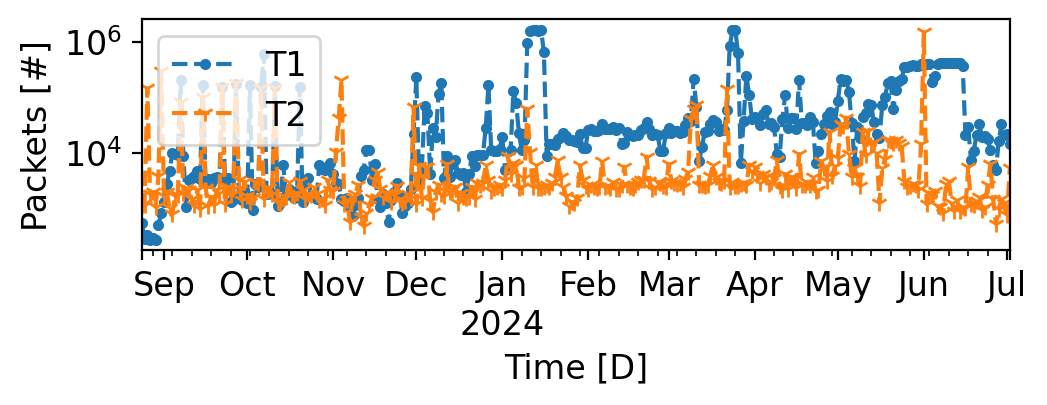

In [31]:
make_overlap_plot_t1t2(filter_set=t1_t2)

100%|██████████| 2169/2169 [08:35<00:00,  4.21it/s]


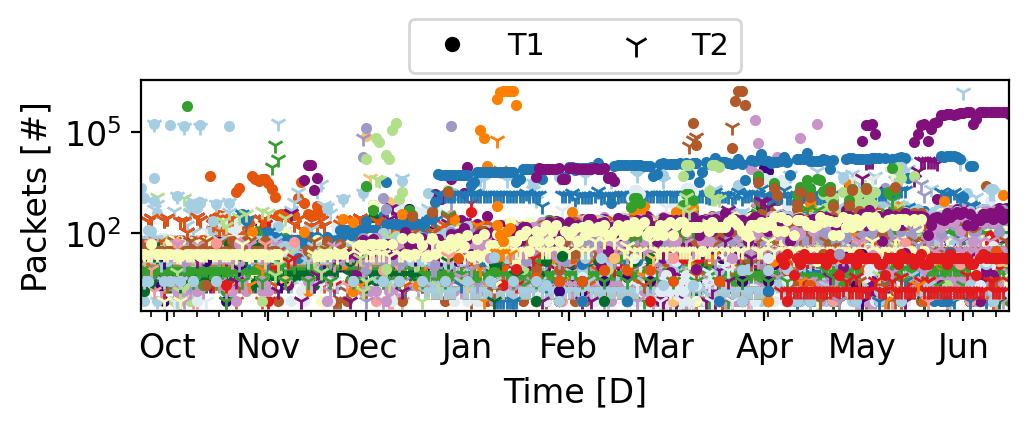

In [32]:
ax = None

for i, addr in enumerate(tqdm(t1_t2)):
    # print("addr: ", str(addr))
    ax = make_overlap_plot_t1t2(filter_set=set([addr]), min_date=datetime(2023,9,23), max_date=datetime(2024,6,15), color=may_colors[i % len(may_colors)], ax=ax)
    # make_overlap_plot_sessions(filter_set=set([addr]), title=str(addr), min_date=datetime(2023,9,23), max_date=datetime(2024,6,15), color=tab_colors[i], ax=ax)

    msize = 9
    col = 'black'
    mfcol = 'black'
    legend_elements = [
        Line2D([0], [0], linestyle='', marker='.', color=col, label='T1', markerfacecolor=mfcol, markersize=msize),
        Line2D([0], [0], linestyle='', marker='1', color=col, label='T2', markerfacecolor=mfcol, markersize=msize),
    ]

    # ax.set_yticks([1, 2, 3, 4, 5, 6], minor=True)

    ax.legend(bbox_to_anchor=(0.5, 1.15), handles=legend_elements, loc='center', ncol=4, fontsize=11)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

    # ax.set_ylim([0, 6])

    # plt.savefig('plots/overlap-addrs-all-sessions.pdf', bbox_inches='tight')

In [33]:

def make_overlap_plot_sessions_t1t2(filter_set, min_date=None, max_date=None, title=None, color=None, ax=None):

    def filter_all_session(df, name):
        return df.filter(pl.col("Source_Address").is_in(filter_set)).select(
            pl.col("Timestamp"),
            pl.col("Source_Address"),
            pl.col("Protocol"),
            pl.col("Session_ID_128")
        ).with_columns(
            pl.col("Timestamp").dt.date().alias("Date"),
        ).group_by([pl.col("Date")]).agg(
            pl.col("Session_ID_128").n_unique().alias(name)
        )


    overlap_t1 = filter_all_session(dft1, "T1")
    overlap_t2 = filter_all_session(dft2, "T2")

    # Create one df

    overlap_df = overlap_t1.join(overlap_t2, on="Date", how="full", coalesce=True)

    # Turn to pandas and reindex.
    plot_df = overlap_df.sort(pl.col("Date")).to_pandas()

    # Reindes timerange.
    if min_date is None:
        min_date = plot_df["Date"].min()
    if max_date is None:
        max_date = plot_df["Date"].max()
    # print(min_date, max_date)
    plot_df = plot_df.set_index("Date")
    range = pd.date_range(start=min_date, end=max_date, freq='D')
    plot_df = plot_df.reindex(index=range)

    # ax = sns.lineplot(plot_df)

    if color is None:
        ax = plot_df.plot(ax=ax, color=color, style=[".--", "1--", "x--", "+--"])
    else:
        ax = plot_df.plot(ax=ax, color=color, style=[".", "1", "x", "+"], legend=False)

    # ax.set_yscale("log")

    ax.set_xlabel("Time [D]")
    ax.set_ylabel("Sessions [#]")

    if title is not None:
        ax.set_title(title)

    # Make vertical lines for the announcement dates
    # for date in vertical_dates:
    #     ax.axvline(date, color="grey", linestyle="--", linewidth=1)

    return ax

<Axes: xlabel='Time [D]', ylabel='Sessions [#]'>

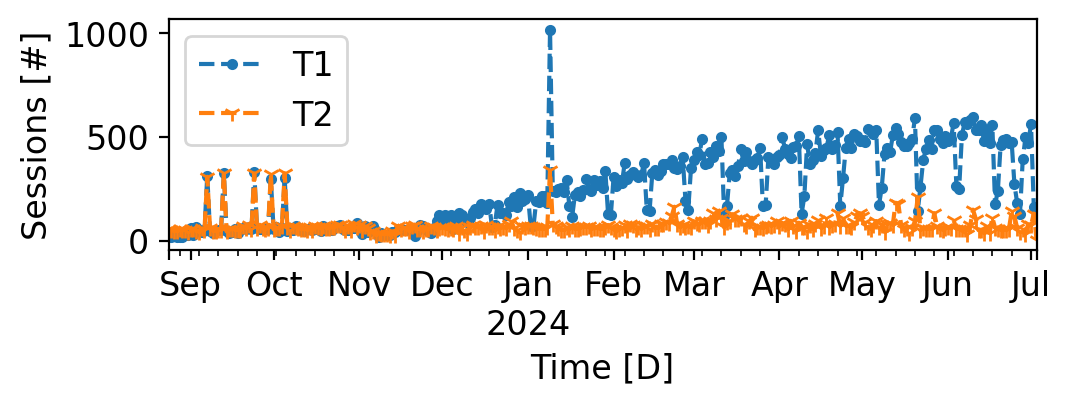

In [34]:
make_overlap_plot_sessions_t1t2(filter_set=t1_t2)

100%|██████████| 2169/2169 [08:34<00:00,  4.21it/s]


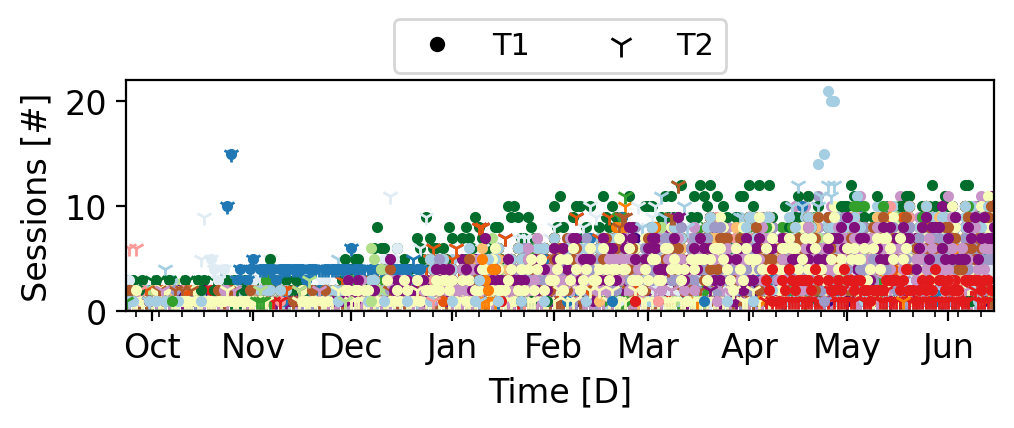

In [35]:
ax = None

for i, addr in enumerate(tqdm(t1_t2)):
    # print("addr: ", str(addr))
    ax = make_overlap_plot_sessions_t1t2(filter_set=set([addr]), min_date=datetime(2023,9,23), max_date=datetime(2024,6,15), color=may_colors[i % len(may_colors)], ax=ax)
    # make_overlap_plot_sessions(filter_set=set([addr]), title=str(addr), min_date=datetime(2023,9,23), max_date=datetime(2024,6,15), color=tab_colors[i], ax=ax)

    msize = 9
    col = 'black'
    mfcol = 'black'
    legend_elements = [
        Line2D([0], [0], linestyle='', marker='.', color=col, label='T1', markerfacecolor=mfcol, markersize=msize),
        Line2D([0], [0], linestyle='', marker='1', color=col, label='T2', markerfacecolor=mfcol, markersize=msize),
    ]

    # ax.set_yticks([1, 2, 3, 4, 5, 6], minor=True)

    ax.legend(bbox_to_anchor=(0.5, 1.15), handles=legend_elements, loc='center', ncol=4, fontsize=11)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

    # ax.set_ylim([0, 6])

    # plt.savefig('plots/overlap-addrs-all-sessions.pdf', bbox_inches='tight')

In [36]:
## Commented out: It's too much.

# ax = None

# for i, addr in enumerate(tqdm(t1_t2)):
#     # print("addr: ", str(addr))
#     make_overlap_plot_sessions_t1t2(filter_set=set([addr]), title=str(addr), min_date=datetime(2023,9,23), max_date=datetime(2024,6,15), color=tab_colors[i])


We should do this differently. The dots are too many to look at. And if we plot them individually, it's too many pictures to look at. 

- If the number of AS is smaller, we could maybe make a picture for each of those.
- Check the **AS types** that show overlap and the **tools**.
- 

In [37]:
# Plot addresses as bars (first to last day).

In [38]:
def filter_t1_and_t2(df):
    return df.filter(pl.col("Source_Address").is_in(t1_t2)).select(
        pl.col("Timestamp"),
        pl.col("Source_Address"),
        pl.col("Protocol"),
    ).with_columns(
        pl.col("Timestamp").dt.date().alias("Date"),
    ).group_by("Source_Address").agg(
        pl.col("Date").min().alias("First"),
        pl.col("Date").max().alias("Last"),
        pl.col("Date").n_unique().alias("Days")
    ).with_columns(
        ((pl.col("Last") - pl.col("First")).dt.total_days() + 1).alias("Duration")
    )


overlap_t1_t1t2 = filter_t1_and_t2(dft1)
overlap_t2_t1t2 = filter_t1_and_t2(dft2)

# overlap_t1t2_df = overlap_t1_t1t2.join(overlap_t2_t1t2, on="Date", how="full", coalesce=True)

In [39]:
overlap_t1_t1t2.dtypes

[Categorical(ordering='physical'), Date, Date, UInt32, Int64]

In [40]:
# Table to show on how many days each address appears.
overlap_t1_t1t2


Source_Address,First,Last,Days,Duration
cat,date,date,u32,i64
"""2a00:6d40:200:5::132""",2024-03-11,2024-03-11,1,1
"""2a03:90c0:83:2908::12""",2024-04-07,2024-04-11,2,5
"""2601:600:c980:5168:c66e:1fff:fe3a:e658""",2024-02-02,2024-02-02,1,1
"""2a02:1748:dd5c:4dc1:c66e:1fff:fe3a:d118""",2024-05-19,2024-05-19,1,1
"""2604:a880:400:d0::2157:1001""",2024-05-14,2024-05-14,1,1
…,…,…,…,…
"""2604:a880:400:d0::1e1b:7001""",2024-06-25,2024-06-25,1,1
"""2a01:e0a:1ea:c2f0:d873:17ff:fe72:b7df""",2024-04-26,2024-06-29,3,65
"""2401:c080:2000:12e3:5400:4ff:feac:b803""",2024-01-09,2024-04-08,7,91


In [41]:
# overlap_t1_t1t2.select(pl.col("Duration"))

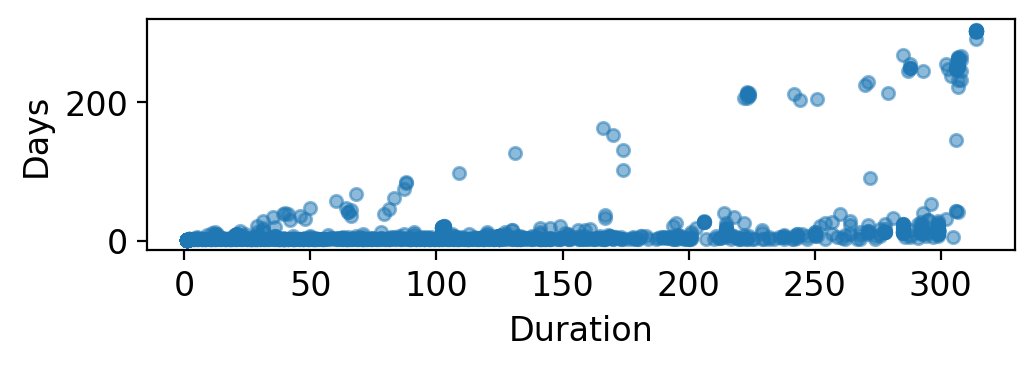

In [42]:
ax = overlap_t1_t1t2.to_pandas().plot.scatter(x="Duration", y="Days", alpha=0.5)

# ax.set_yscale("log")

# Maybe this should be a heatmap ...

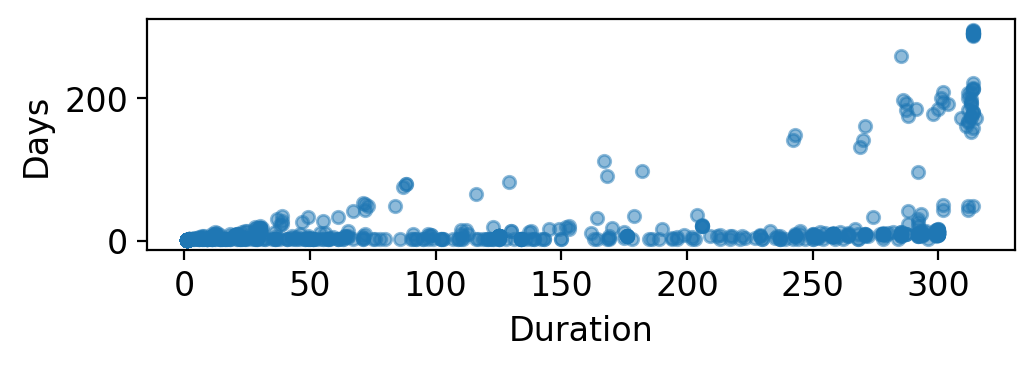

In [43]:
ax = overlap_t2_t1t2.to_pandas().plot.scatter(x="Duration", y="Days", alpha=0.5)

# ax.set_yscale("log")

# Maybe this should be a heatmap ...

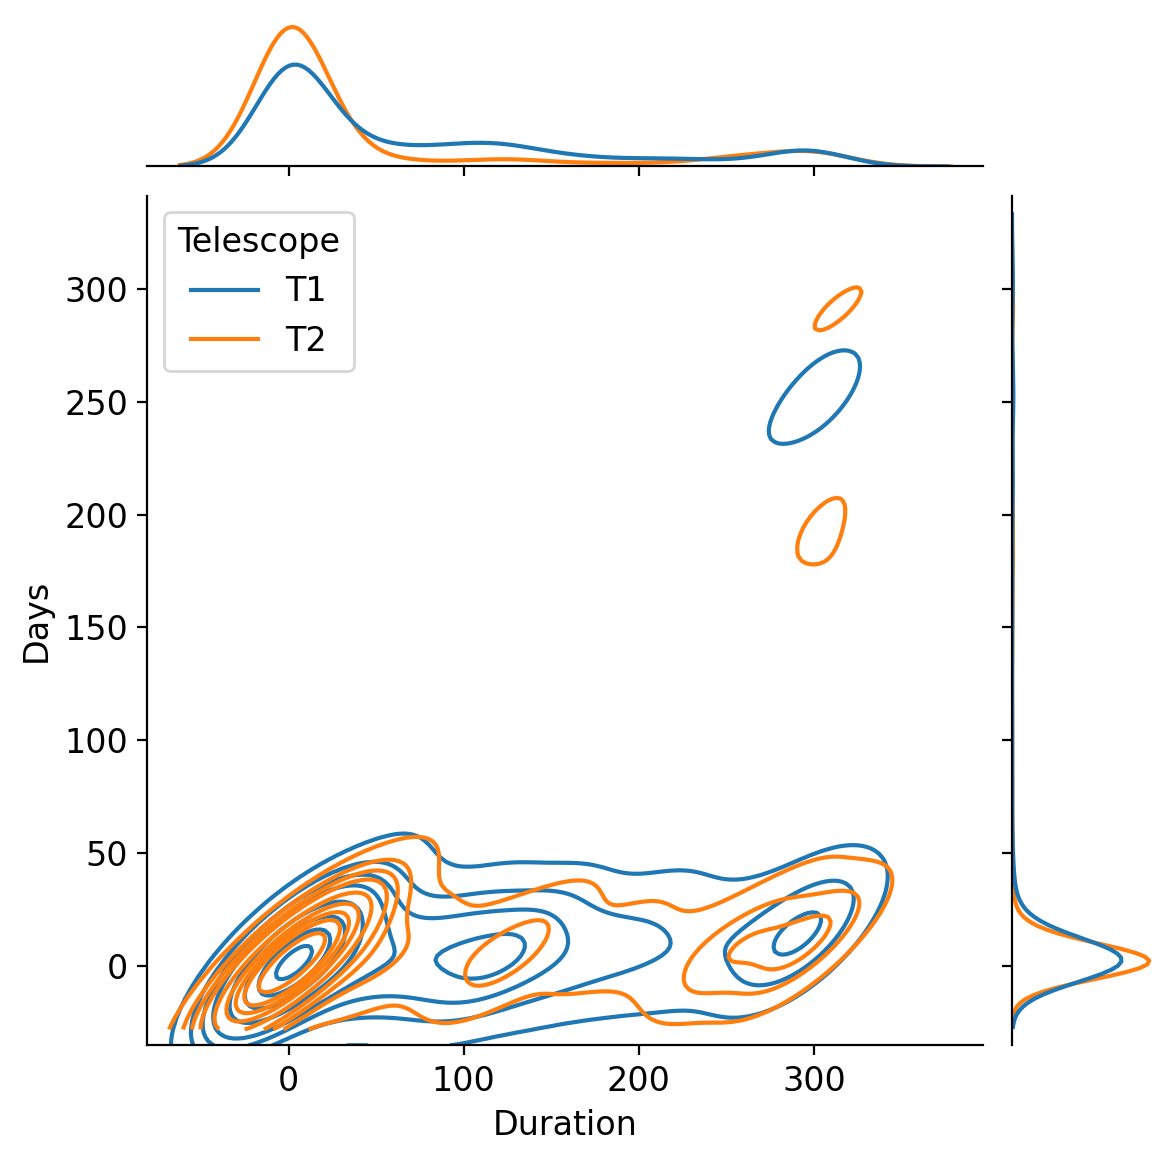

In [44]:

# pddf = overlap_t1_t1t2.to_pandas()
pddf = pl.concat([overlap_t1_t1t2.with_columns(
    pl.lit("T1").alias("Telescope")
), overlap_t2_t1t2.with_columns(
    pl.lit("T2").alias("Telescope")
)]).to_pandas()


ax = sns.jointplot(data=pddf, x="Duration", y="Days", kind="kde", hue="Telescope")

# plt.axhline(y=1, color='grey', linestyle='--')
# plt.axvline(x=1, color='grey', linestyle='--')

sns.move_legend(ax.ax_joint, "upper left", title='Telescope')

<Axes: xlabel='Days', ylabel='Density'>

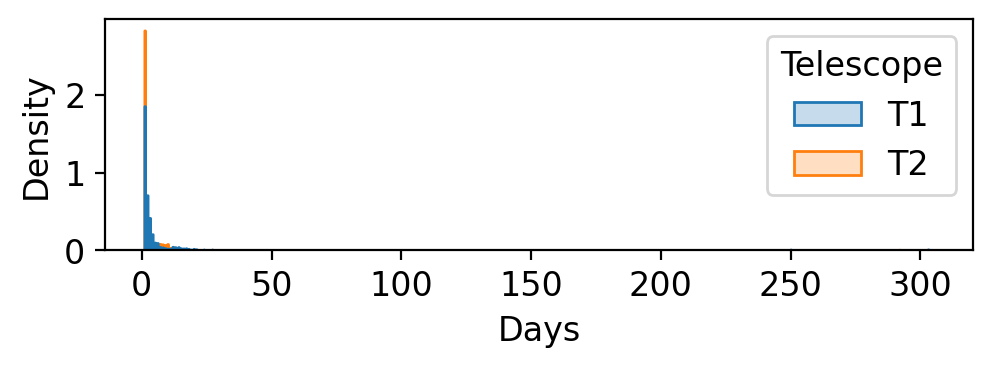

In [45]:

# pddf = overlap_t1_t1t2.to_pandas()
pddf = pl.concat([overlap_t1_t1t2.with_columns(
    pl.lit("T1").alias("Telescope")
), overlap_t2_t1t2.with_columns(
    pl.lit("T2").alias("Telescope")
)]).to_pandas()


sns.histplot(
    pddf, x="Days", hue="Telescope", element="step",
    stat="density", common_norm=False,
)

In [46]:
# distribution to show the days the address "spanned" (first to last appearance).

## Explore Scan campaigns in "seen by all"

In [47]:
def day_count(df, addr):
    return df.filter(pl.col("Source_Address") == addr).with_columns(
        pl.col("Timestamp").dt.date().alias("Date"),
    )["Date"].n_unique()

0: 2001:253:ff:4301:3673:79ff:fe91:48b8
days: 35|13|2|2
full width: 5.6
one unit is 0.01789137380191693
delta: 121
this should be: 2.1648562300319485
9254240|137224|3|2
98.5|1.5|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 51
this should be: 0.9124600638977635


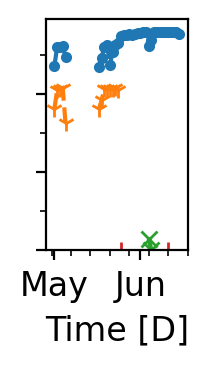

In [48]:
# seen_by_all

overlap_lst = list(seen_by_all)

idx = 0
addr = overlap_lst[idx]
print(f"{idx}: {addr}")
print(f"days: {day_count(dft1, addr)}|{day_count(dft2, addr)}|{day_count(dft3, addr)}|{day_count(dft4, addr)}")

mind=datetime(2024, 2, 15)
maxd=datetime(2024, 6, 15)

# Estimate how wide the picture should be.
full_width = 8 * 0.7
full_height = 3 * 0.5
unit = full_width / (end_date - start_date).days
print(f"full width: {full_width}")
print(f"one unit is {unit}")

delta = (maxd - mind).days
width = delta * unit
print(f"delta: {delta}")
print(f"this should be: {width}")

# make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date)
ax = make_overlap_plot(
    filter_set=set([addr]),
    # min_date=mind,
    # max_date=maxd,
    # figsize=(width, full_height)
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.get_legend().remove()
ax.set_ylim([1, 10**5.9])
ax.yaxis.set_minor_locator(mticker.FixedLocator([10**1, 10**3, 10**5]))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())
# ax.set_yticks([10**0, 10**2, 10**4, 10**6])
# ylabels = ax.get_yticklabels()
# ax.set_yticklabels(ylabels[0:2])
# plt.show()
ax.set_ylabel(None)
plt.tick_params(axis='y', which='both', labelleft=False)
plt.savefig(f"plots/overlap-addrs-all-packets-series-{idx}.pdf", bbox_inches='tight')

# for i, data in enumerate([dft1, dft2, dft3, dft4]):
#     print(data.filter(pl.col("Source_Address") == addr).group_by("scantool").agg(
#         pl.col("Source_Address").count()
#     ))
#     # sns.histplot(data = data.filter(pl.col("Source_Address") == addr).to_pandas(), x="scantool")
#     # plt.show()

1: 2a01:190:151a::5ba:100


days: 1|4|1|1
590367|65322|5|5
90.0|10.0|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 48
this should be: 0.8587859424920127


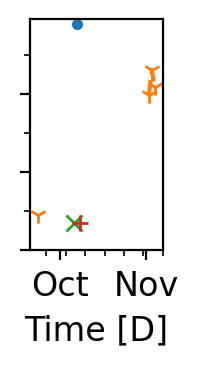

In [49]:
idx = 1

addr = overlap_lst[idx]
print(f"{idx}: {addr}")
print(f"days: {day_count(dft1, addr)}|{day_count(dft2, addr)}|{day_count(dft3, addr)}|{day_count(dft4, addr)}")

# make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date)
ax = make_overlap_plot(
    filter_set=set([addr]),
    # min_date=datetime(2023, 11, 15),
    # max_date=datetime(2023, 12, 15),
    # figsize=(2 * 0.7, 3 * 0.5)
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.get_legend().remove()
ax.set_ylim([1, 10**5.9])
ax.yaxis.set_minor_locator(mticker.FixedLocator([10**1, 10**3, 10**5]))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())
ax.set_ylabel(None)
plt.tick_params(axis='y', which='both', labelleft=False)
# plt.show()
plt.savefig(f"plots/overlap-addrs-all-packets-series-{idx}.pdf", bbox_inches='tight')

# for data in [dft1, dft2, dft3, dft4]:
#     print(data.filter(pl.col("Source_Address") == addr).group_by("scantool").agg(
#         pl.col("Source_Address").count()
#     ))
#     # ax = sns.histplot(data = data.filter(pl.col("Source_Address") == addr).to_pandas(), x="scantool")
#     # plt.show()

# # Already mentioned in the overlap during the initial period.

2: 2001:da8:bf:300:ae1f:6bff:fefb:8b62


days: 6|3|1|1
135906|64233|1|9
67.9|32.1|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 171
this should be: 3.059424920127795


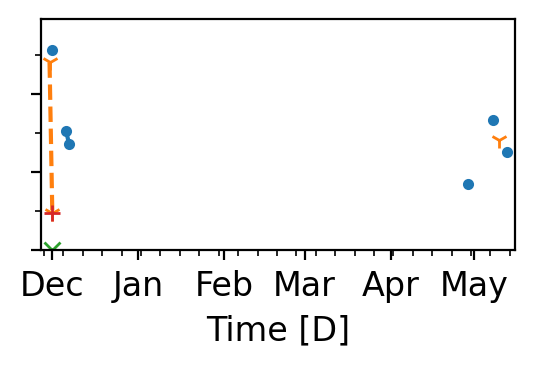

In [50]:
idx = 2

addr = overlap_lst[idx]
print(f"{idx}: {addr}")
print(f"days: {day_count(dft1, addr)}|{day_count(dft2, addr)}|{day_count(dft3, addr)}|{day_count(dft4, addr)}")

# make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date)
ax = make_overlap_plot(
    filter_set=set([addr]),
    # min_date=datetime(2024, 4, 15),
    # max_date=datetime(2024, 5, 20),
    # figsize=(2.2 * 0.7, 3 * 0.5)
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.get_legend().remove()
ax.set_ylim([1, 10**5.9])
ax.yaxis.set_minor_locator(mticker.FixedLocator([10**1, 10**3, 10**5]))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())
ax.set_ylabel(None)
plt.tick_params(axis='y', which='both', labelleft=False)
# plt.show()
plt.savefig(f"plots/overlap-addrs-all-packets-series-{idx}.pdf", bbox_inches='tight')

# for data in [dft1, dft2, dft3, dft4]:
#     print(data.filter(pl.col("Source_Address") == addr).group_by("scantool").agg(
#         pl.col("Source_Address").count()
#     ))
#     # ax = sns.histplot(data = data.filter(pl.col("Source_Address") == addr).to_pandas(), x="scantool")
#     # plt.show()


3: 2602:ffd5:1:164::1
days: 33|18|4|3
211632|3932|4|3
98.2|1.8|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 180
this should be: 3.2204472843450476


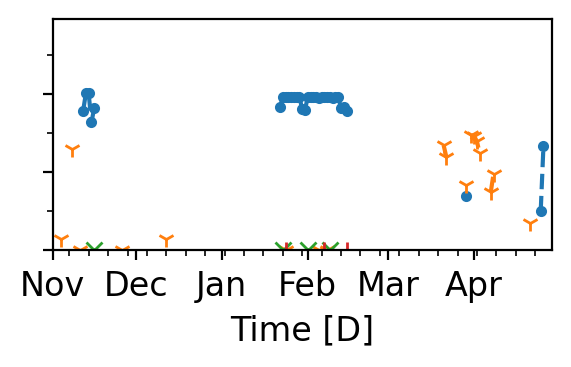

In [51]:
idx = 3

addr = overlap_lst[idx]
print(f"{idx}: {addr}")
print(f"days: {day_count(dft1, addr)}|{day_count(dft2, addr)}|{day_count(dft3, addr)}|{day_count(dft4, addr)}")

# make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date)
ax = make_overlap_plot(
    filter_set=set([addr]),
    # min_date=datetime(2024, 3, 15),
    # max_date=datetime(2024, 5, 1),
    # figsize=(2.2 * 0.7, 3 * 0.5)
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.get_legend().remove()
ax.set_ylim([1, 10**5.9])
ax.yaxis.set_minor_locator(mticker.FixedLocator([10**1, 10**3, 10**5]))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())
ax.set_ylabel(None)
plt.tick_params(axis='y', which='both', labelleft=False)
# plt.show()
plt.savefig(f"plots/overlap-addrs-all-packets-series-{idx}.pdf", bbox_inches='tight')

# for data in [dft1, dft2, dft3, dft4]:
#     print(data.filter(pl.col("Source_Address") == addr).group_by("scantool").agg(
#         pl.col("Source_Address").count()
#     ))
#     # ax = sns.histplot(data = data.filter(pl.col("Source_Address") == addr).to_pandas(), x="scantool")
#     # plt.show()


4: 2a01:190:151a:1::5ba:100
days: 7|1|1|1
524551|9|5|5
100.0|0.0|0.0|0.0
current distance: 28, increasing to 40
full width: 5.6
one unit is 0.01789137380191693
delta: 40
this should be: 0.7156549520766773


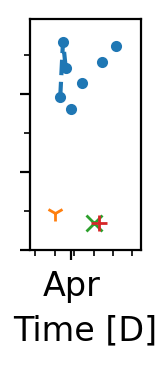

In [52]:
idx = 4

addr = overlap_lst[idx]
print(f"{idx}: {addr}")
print(f"days: {day_count(dft1, addr)}|{day_count(dft2, addr)}|{day_count(dft3, addr)}|{day_count(dft4, addr)}")

# make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date)
ax = make_overlap_plot(
    filter_set=set([addr]),
    # min_date=datetime(2024, 4, 15),
    # max_date=datetime(2024, 5, 15),
    # figsize=(2.2 * 0.7, 3 * 0.5)
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.get_legend().remove()
ax.set_ylim([1, 10**5.9])
ax.yaxis.set_minor_locator(mticker.FixedLocator([10**1, 10**3, 10**5]))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())
ax.set_ylabel(None)
plt.tick_params(axis='y', which='both', labelleft=False)
# plt.show()
plt.savefig(f"plots/overlap-addrs-all-packets-series-{idx}.pdf", bbox_inches='tight')

# for data in [dft1, dft2, dft3, dft4]:
#     print(data.filter(pl.col("Source_Address") == addr).group_by("scantool").agg(
#         pl.col("Source_Address").count()
#     ))
#     # ax = sns.histplot(data = data.filter(pl.col("Source_Address") == addr).to_pandas(), x="scantool")
#     # plt.show()


5: 2001:550:9005:1000::11
days: 7|13|1|3


43|20245|352|24
0.2|98.0|1.7|0.1
current distance: 30, increasing to 40
full width: 5.6
one unit is 0.01789137380191693
delta: 40
this should be: 0.7156549520766773


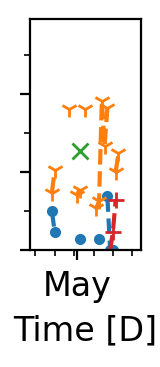

In [53]:
idx = 5

addr = overlap_lst[idx]
print(f"{idx}: {addr}")
print(f"days: {day_count(dft1, addr)}|{day_count(dft2, addr)}|{day_count(dft3, addr)}|{day_count(dft4, addr)}")

# make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date)
ax = make_overlap_plot(
    filter_set=set([addr]),
    # min_date=datetime(2024, 3, 15),
    # max_date=datetime(2024, 5, 1),
    # figsize=(2.2 * 0.7, 3 * 0.5)
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.get_legend().remove()
ax.set_ylim([1, 10**5.9])
ax.yaxis.set_minor_locator(mticker.FixedLocator([10**1, 10**3, 10**5]))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())
ax.set_ylabel(None)
plt.tick_params(axis='y', which='both', labelleft=False)
# plt.show()
plt.savefig(f"plots/overlap-addrs-all-packets-series-{idx}.pdf", bbox_inches='tight')

# for data in [dft1, dft2, dft3, dft4]:
#     print(data.filter(pl.col("Source_Address") == addr).group_by("scantool").agg(
#         pl.col("Source_Address").count()
#     ))
#     # ax = sns.histplot(data = data.filter(pl.col("Source_Address") == addr).to_pandas(), x="scantool")
#     # plt.show()


6: 2001:550:9005:2000::11
days: 7|12|1|2


75|19891|368|22
0.4|97.7|1.8|0.1
current distance: 28, increasing to 40
full width: 5.6
one unit is 0.01789137380191693
delta: 40
this should be: 0.7156549520766773


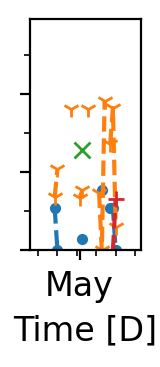

In [54]:
idx = 6

addr = overlap_lst[idx]
print(f"{idx}: {addr}")
print(f"days: {day_count(dft1, addr)}|{day_count(dft2, addr)}|{day_count(dft3, addr)}|{day_count(dft4, addr)}")

# make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date)
ax = make_overlap_plot(
    filter_set=set([addr]),
    # min_date=datetime(2024, 4, 15),
    # max_date=datetime(2024, 5, 15),
    # figsize=(5 * 0.7, 3 * 0.5)
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.get_legend().remove()
ax.set_ylim([1, 10**5.9])
ax.yaxis.set_minor_locator(mticker.FixedLocator([10**1, 10**3, 10**5]))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())
ax.set_ylabel(None)
plt.tick_params(axis='y', which='both', labelleft=False)
# plt.show()
plt.savefig(f"plots/overlap-addrs-all-packets-series-{idx}.pdf", bbox_inches='tight')

# for data in [dft1, dft2, dft3, dft4]:
#     print(data.filter(pl.col("Source_Address") == addr).group_by("scantool").agg(
#         pl.col("Source_Address").count()
#     ))
#     # ax = sns.histplot(data = data.filter(pl.col("Source_Address") == addr).to_pandas(), x="scantool")
#     # plt.show()


7: 2605:6400:10:6a8:bc7a:408:1ad:e7e6


days: 10|6|8|10
9639083|65508|11|24
99.3|0.7|0.0|0.0
current distance: 18, increasing to 40
full width: 5.6
one unit is 0.01789137380191693
delta: 40
this should be: 0.7156549520766773


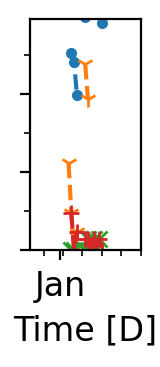

In [55]:
idx = 7

addr = overlap_lst[idx]
print(f"{idx}: {addr}")
print(f"days: {day_count(dft1, addr)}|{day_count(dft2, addr)}|{day_count(dft3, addr)}|{day_count(dft4, addr)}")

# make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date)
ax = make_overlap_plot(
    filter_set=set([addr]),
    # min_date=datetime(2024, 4, 15),
    # max_date=datetime(2024, 5, 15),
    # figsize=(4 * 0.7, 3 * 0.5)
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.get_legend().remove()
ax.set_ylim([1, 10**5.9])
ax.yaxis.set_minor_locator(mticker.FixedLocator([10**1, 10**3, 10**5]))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())
ax.set_ylabel(None)
plt.tick_params(axis='y', which='both', labelleft=False)
# plt.show()
plt.savefig(f"plots/overlap-addrs-all-packets-series-{idx}.pdf", bbox_inches='tight')

# for data in [dft1, dft2, dft3, dft4]:
#     # print(data.filter(pl.col("Source_Address") == addr).group_by("scantool").agg(
#     #     pl.col("Source_Address").count()
#     # ))
#     print(data.filter((pl.col("Source_Address") == addr) & (pl.col("Timestamp") > datetime(2024,2,2))).group_by("scantool").agg(
#         pl.col("Source_Address").count()
#     ))
#     # ax = sns.histplot(data = data.filter(pl.col("Source_Address") == addr).to_pandas(), x="scantool")
#     # plt.show()


8: 2401:c080:1c02:d91:5400:4ff:feaa:f563


days: 2|3|1|2
74206|4567|1|7
94.2|5.8|0.0|0.0
current distance: 8, increasing to 40
full width: 5.6
one unit is 0.01789137380191693
delta: 40
this should be: 0.7156549520766773


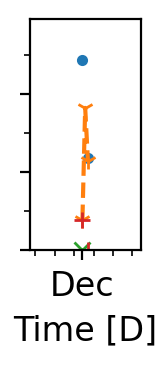

In [56]:
idx = 8

addr = overlap_lst[idx]
print(f"{idx}: {addr}")
print(f"days: {day_count(dft1, addr)}|{day_count(dft2, addr)}|{day_count(dft3, addr)}|{day_count(dft4, addr)}")

# make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date)
ax = make_overlap_plot(
    filter_set=set([addr]),
    # min_date=datetime(2024, 4, 15),
    # max_date=datetime(2024, 5, 15),
    # figsize=(2 * 0.7, 3 * 0.5)
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
ax.get_legend().remove()
ax.set_ylim([1, 10**5.9])
ax.yaxis.set_minor_locator(mticker.FixedLocator([10**1, 10**3, 10**5]))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())
ax.set_ylabel(None)
plt.tick_params(axis='y', which='both', labelleft=False)
# plt.show()
plt.savefig(f"plots/overlap-addrs-all-packets-series-{idx}.pdf", bbox_inches='tight')

# for data in [dft1, dft2, dft3, dft4]:
#     print(data.filter(pl.col("Source_Address") == addr).group_by("scantool").agg(
#         pl.col("Source_Address").count()
#     ))
#     # ax = sns.histplot(data = data.filter(pl.col("Source_Address") == addr).to_pandas(), x="scantool")
#     # plt.show()


9: 2401:c080:1c00:2d8c:5400:4ff:feb3:fd43


days: 1|1|1|1
delta: 123
this should be: 2.2006389776357826
149901|812|1|36
99.4|0.5|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 123
this should be: 2.2006389776357826


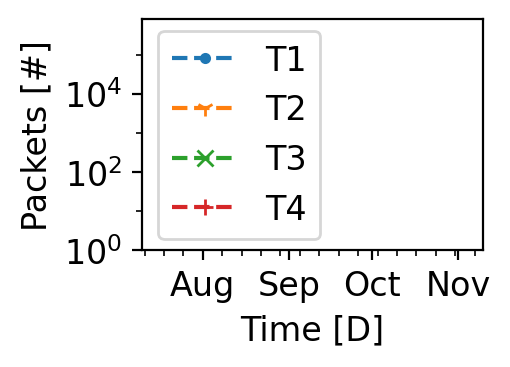

In [57]:
idx = 9

addr = overlap_lst[idx]
print(f"{idx}: {addr}")
print(f"days: {day_count(dft1, addr)}|{day_count(dft2, addr)}|{day_count(dft3, addr)}|{day_count(dft4, addr)}")

mind=datetime(2023, 7, 10)
maxd=datetime(2023, 11, 10)

delta = (maxd - mind).days
width = delta * unit
print(f"delta: {delta}")
print(f"this should be: {width}")

# make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date)
ax = make_overlap_plot(
    filter_set=set([addr]),
    min_date=mind,
    max_date=maxd,
    figsize=(width, full_height)
)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())
# ax.get_legend().remove()
ax.legend(loc="center left")
ax.set_ylim([1, 10**5.9])
ax.yaxis.set_minor_locator(mticker.FixedLocator([10**1, 10**3, 10**5]))
ax.yaxis.set_minor_formatter(mticker.NullFormatter())
# ax.set_ylabel(None)
# plt.tick_params(axis='y', which='both', labelleft=False)
# plt.show()
plt.savefig(f"plots/overlap-addrs-all-packets-series-{idx}.pdf", bbox_inches='tight')

# for data in [dft1, dft2, dft3, dft4]:
#     print(data.filter(pl.col("Source_Address") == addr).group_by("scantool").agg(
#         pl.col("Source_Address").count()
#     ))
#     # ax = sns.histplot(data = data.filter(pl.col("Source_Address") == addr).to_pandas(), x="scantool")
#     # plt.show()


## Active days

In [58]:
def filter_t1_and_t2(df):
    return df.filter(pl.col("Source_Address").is_in(t1_t2)).select(
        pl.col("Timestamp"),
        pl.col("Source_Address"),
        pl.col("Protocol"),
    ).with_columns(
        pl.col("Timestamp").dt.date().alias("Date"),
    ).group_by("Source_Address").agg(
        pl.col("Date").min().alias("First"),
        pl.col("Date").max().alias("Last"),
        pl.col("Date").n_unique().alias("Days")
    ).with_columns(
        ((pl.col("Last") - pl.col("First")).dt.total_days() + 1).alias("Duration")
    )


overlap_t1_t1t2 = filter_t1_and_t2(dft1)
overlap_t2_t1t2 = filter_t1_and_t2(dft2)

In [59]:
len(t1_t2)

2169

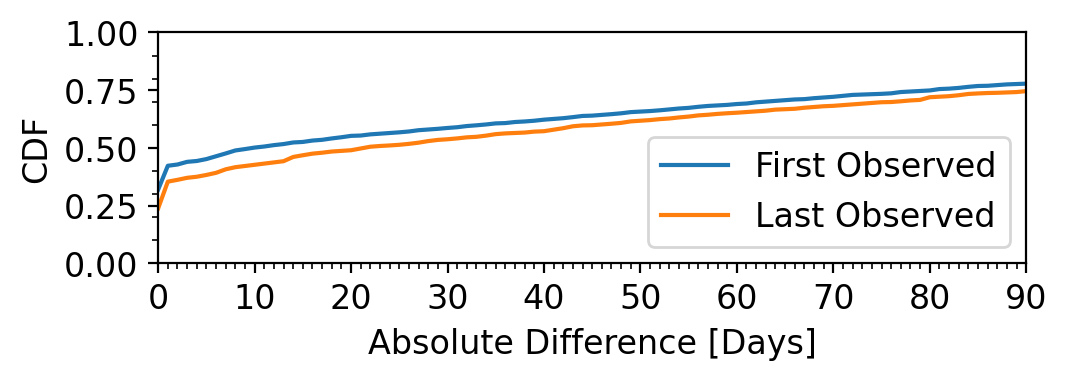

In [60]:
dates_abs_first_df = overlap_t1_t1t2.with_columns(
    pl.col("First").alias("First T1"),
    pl.col("Last").alias("Last T1"),
).select(
    pl.col("Source_Address"),
    pl.col("First T1"),
    pl.col("Last T1"),
).join(overlap_t2_t1t2.with_columns(
    pl.col("First").alias("First T2"),
    pl.col("Last").alias("Last T2"),
).select(
    pl.col("Source_Address"),
    pl.col("First T2"),
    pl.col("Last T2"),
), on="Source_Address").with_columns(
    (abs(pl.col("First T1") - pl.col("First T2"))).dt.total_days().alias("First Diff"),
    (abs(pl.col("Last T1") - pl.col("Last T2"))).dt.total_days().alias("Last Diff")
).group_by("First Diff").agg(
    pl.col("Source_Address").count().alias("Count")
).with_columns(
    (pl.col("Count") / pl.col("Count").sum() * 100).round(2).alias("Share")
).sort("First Diff")

dates_abs_last_df = overlap_t1_t1t2.with_columns(
    pl.col("First").alias("First T1"),
    pl.col("Last").alias("Last T1"),
).select(
    pl.col("Source_Address"),
    pl.col("First T1"),
    pl.col("Last T1"),
).join(overlap_t2_t1t2.with_columns(
    pl.col("First").alias("First T2"),
    pl.col("Last").alias("Last T2"),
).select(
    pl.col("Source_Address"),
    pl.col("First T2"),
    pl.col("Last T2"),
), on="Source_Address").with_columns(
    (abs(pl.col("First T1") - pl.col("First T2"))).dt.total_days().alias("First Diff"),
    (abs(pl.col("Last T1") - pl.col("Last T2"))).dt.total_days().alias("Last Diff")
).group_by("Last Diff").agg(
    pl.col("Source_Address").count().alias("Count")
).with_columns(
    (pl.col("Count") / pl.col("Count").sum() * 100).round(2).alias("Share")
).sort("Last Diff")

xs_first = []
ys_first = []

cum = 0
last_x = 0
for x, y in zip(dates_abs_first_df["First Diff"], dates_abs_first_df["Share"]):

    for missing in range(last_x + 1, x):
        xs_first.append(missing)
        ys_first.append(cum)

    cum += (y / 100)

    xs_first.append(x)
    ys_first.append(cum)

    last_x = x

xs_last = []
ys_last = []

cum = 0
last_x = 0
for x, y in zip(dates_abs_last_df["Last Diff"], dates_abs_last_df["Share"]):

    for missing in range(last_x + 1, x):
        xs_last.append(missing)
        ys_last.append(cum)

    cum += (y / 100)

    xs_last.append(x)
    ys_last.append(cum)

    last_x = x

# print(xs_first)
# print(len(xs_first))

# plotdf = pd.DataFrame({"Diff [D]": xs_first, "CDF": ys_first})
# ax = plotdf.plot(x="Diff [D]", y="CDF")

plt.plot(xs_first, ys_first, label="First Observed")
plt.plot(xs_last, ys_last, label="Last Observed")

ax = plt.gca()

ax.legend(loc="lower right")

ax.set_xlim([0, 90])
ax.set_ylim([0, 1.0])

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

# # plt.axvline(x=1, color='blue', linestyle='--')
# # plt.axhline(y=0.4, color='grey', linestyle='--')

# # plt.axvline(x=5, color='grey', linestyle='--')
# plt.axhline(y=0.75, color='grey', linestyle='--')

ax.set_xlabel("Absolute Difference [Days]")
ax.set_ylabel("CDF")

plt.savefig('plots/overlap-observation-diff.pdf', bbox_inches='tight')

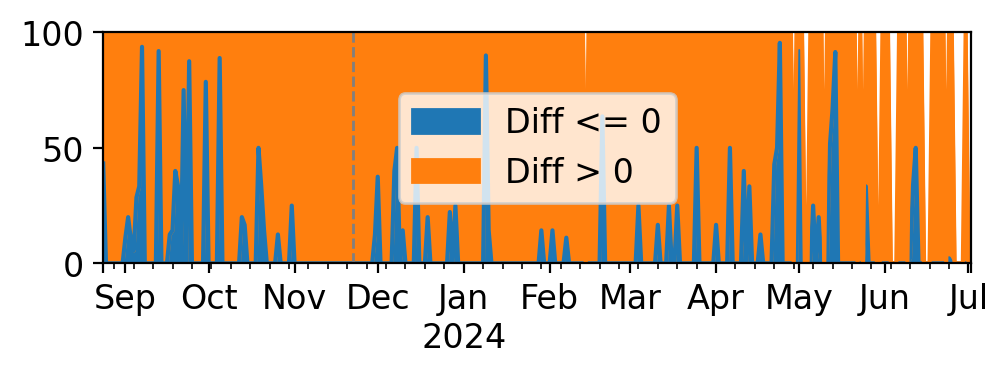

In [61]:
dates_abs_first_df = overlap_t1_t1t2.with_columns(
    pl.col("First").alias("First T1"),
    pl.col("Last").alias("Last T1"),
).select(
    pl.col("Source_Address"),
    pl.col("First T1"),
    pl.col("Last T1"),
).join(overlap_t2_t1t2.with_columns(
    pl.col("First").alias("First T2"),
    pl.col("Last").alias("Last T2"),
).select(
    pl.col("Source_Address"),
    pl.col("First T2"),
    pl.col("Last T2"),
), on="Source_Address").with_columns(
    (abs(pl.col("First T1") - pl.col("First T2"))).dt.total_days().alias("First Diff"),
    (abs(pl.col("Last T1") - pl.col("Last T2"))).dt.total_days().alias("Last Diff")
)

threshold = 0

pos_label = f"Diff <= {threshold}" # f"Meets Threshold"
neg_label = f"Diff > {threshold}" # f"Fails Threshold"

plot_df = dates_abs_first_df.with_columns(
    pl.min_horizontal(["First T1", "First T2"]).alias("First"),
    (pl.when(pl.col('First Diff')<=threshold)
        .then(1)
        .otherwise(0)).alias(pos_label),
    (pl.when(pl.col('First Diff') > threshold)
        .then(1)
        .otherwise(0)).alias(neg_label),
).sort("First").group_by("First").agg(
    pl.col(pos_label).sum().alias(pos_label),
    pl.col(neg_label).sum().alias(neg_label),
).to_pandas()

range = pd.date_range(start=start_date, end=end_date, freq='D')
plot_df = plot_df.set_index("First").reindex(index=range)
# plot_df = plot_df.groupby(pd.Grouper(freq="1W")).agg("sum")

plot_df = plot_df.fillna(0)

plot_df["Total"] = plot_df[pos_label] + plot_df[neg_label]
plot_df[pos_label] = plot_df[pos_label] / plot_df["Total"] * 100
plot_df[neg_label] = plot_df[neg_label] / plot_df["Total"] * 100

plot_df = plot_df.drop("Total", axis=1)

ax = plot_df.plot.area()

ax.set_ylim([0, 100])
ax.axvline(vertical_dates[0], color="grey", linestyle="--", linewidth=1)

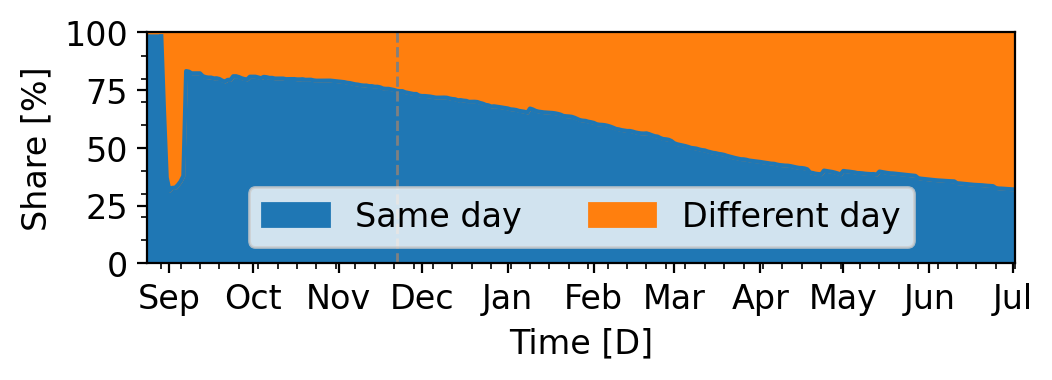

In [ ]:
## Figure 16b

dates_abs_first_df = overlap_t1_t1t2.with_columns(
    pl.col("First").alias("First T1"),
    pl.col("Last").alias("Last T1"),
).select(
    pl.col("Source_Address"),
    pl.col("First T1"),
    pl.col("Last T1"),
).join(overlap_t2_t1t2.with_columns(
    pl.col("First").alias("First T2"),
    pl.col("Last").alias("Last T2"),
).select(
    pl.col("Source_Address"),
    pl.col("First T2"),
    pl.col("Last T2"),
), on="Source_Address").with_columns(
    (abs(pl.col("First T1") - pl.col("First T2"))).dt.total_days().alias("First Diff"),
    (abs(pl.col("Last T1") - pl.col("Last T2"))).dt.total_days().alias("Last Diff")
)

threshold = 0

pos_label = f"Same day" # f"Meets Threshold"
neg_label = f"Different day" # f"Fails Threshold"

plot_df = dates_abs_first_df.with_columns(
    pl.max_horizontal(["First T1", "First T2"]).alias("First"),
    # pl.min_horizontal(["First T1", "First T2"]).alias("First"),
    (pl.when(pl.col('First Diff')<=threshold)
        .then(1)
        .otherwise(0)).alias(pos_label),
    (pl.when(pl.col('First Diff') > threshold)
        .then(1)
        .otherwise(0)).alias(neg_label),
).sort("First").group_by("First").agg(
    pl.col(pos_label).sum().alias(pos_label),
    pl.col(neg_label).sum().alias(neg_label),
).to_pandas()

# start_date = datetime(2023,9,8)

range = pd.date_range(start=start_date, end=end_date, freq='D')
plot_df = plot_df.set_index("First").reindex(index=range)
plot_df["Total"] = plot_df[pos_label] + plot_df[neg_label]

plot_df = plot_df.fillna(0)

plot_df["Total"] = plot_df["Total"].cumsum()
plot_df[pos_label] = plot_df[pos_label].cumsum()
plot_df[neg_label] = plot_df[neg_label].cumsum()

plot_df[pos_label] = plot_df[pos_label] / plot_df["Total"] * 100
plot_df[neg_label] = plot_df[neg_label] / plot_df["Total"] * 100

plot_df = plot_df.drop("Total", axis=1)

ax = plot_df.plot.area()

ax.set_ylim([0, 100])
ax.axvline(vertical_dates[0], color="grey", linestyle="--", linewidth=1)

# ax.axhline(50, color="grey", linestyle="--", linewidth=1)

ax.set_xlabel("Time [D]")

ax.set_ylabel("Share [%]")

ax.yaxis.set_major_locator(ticker.MultipleLocator(25))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

# ax.legend(bbox_to_anchor=(0.5, 1.15), handles=legend_elements, loc='center', ncol=4, fontsize=11)
ax.legend(loc='lower center', ncol=2) #, ncol=4, fontsize=11)

plt.savefig('plots/overlap-cumulative-first-observation.pdf', bbox_inches='tight')

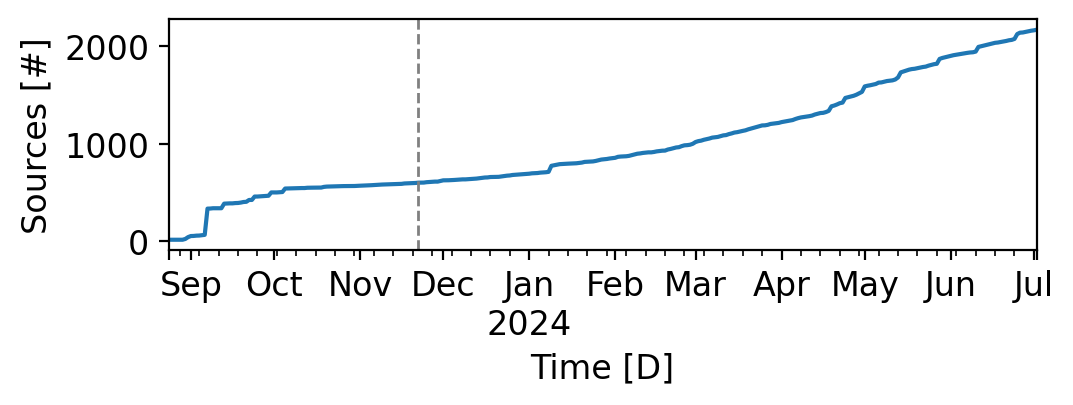

In [95]:
dates_abs_first_df = overlap_t1_t1t2.with_columns(
    pl.col("First").alias("First T1"),
    pl.col("Last").alias("Last T1"),
).select(
    pl.col("Source_Address"),
    pl.col("First T1"),
    pl.col("Last T1"),
).join(overlap_t2_t1t2.with_columns(
    pl.col("First").alias("First T2"),
    pl.col("Last").alias("Last T2"),
).select(
    pl.col("Source_Address"),
    pl.col("First T2"),
    pl.col("Last T2"),
), on="Source_Address").with_columns(
    (abs(pl.col("First T1") - pl.col("First T2"))).dt.total_days().alias("First Diff"),
    (abs(pl.col("Last T1") - pl.col("Last T2"))).dt.total_days().alias("Last Diff")
)

threshold = 0

pos_label = f"Same day" # f"Meets Threshold"
neg_label = f"Different day" # f"Fails Threshold"

plot_df = dates_abs_first_df.with_columns(
    pl.max_horizontal(["First T1", "First T2"]).alias("First"),
    # pl.min_horizontal(["First T1", "First T2"]).alias("First"),
    (pl.when(pl.col('First Diff')<=threshold)
        .then(1)
        .otherwise(0)).alias(pos_label),
    (pl.when(pl.col('First Diff') > threshold)
        .then(1)
        .otherwise(0)).alias(neg_label),
).sort("First").group_by("First").agg(
    pl.col(pos_label).sum().alias(pos_label),
    pl.col(neg_label).sum().alias(neg_label),
).to_pandas()

range = pd.date_range(start=start_date, end=end_date, freq='D')
plot_df = plot_df.set_index("First").reindex(index=range)
plot_df["Total"] = plot_df[pos_label] + plot_df[neg_label]

plot_df = plot_df.fillna(0)

plot_df["Total"] = plot_df["Total"].cumsum()
# plot_df[pos_label] = plot_df[pos_label].cumsum()
# plot_df[neg_label] = plot_df[neg_label].cumsum()

# plot_df[pos_label] = plot_df[pos_label] / plot_df["Total"] * 100
# plot_df[neg_label] = plot_df[neg_label] / plot_df["Total"] * 100

plot_df = plot_df.drop(pos_label, axis=1)
plot_df = plot_df.drop(neg_label, axis=1)

# ax = plot_df.plot.area()

ax = plot_df.plot(legend=False)

# ax.set_ylim([0, 100])
ax.axvline(vertical_dates[0], color="grey", linestyle="--", linewidth=1)

# # ax.axhline(50, color="grey", linestyle="--", linewidth=1)

ax.set_xlabel("Time [D]")

ax.set_ylabel("Sources [#]")

# ax.yaxis.set_major_locator(ticker.MultipleLocator(25))
# ax.yaxis.set_minor_locator(ticker.MultipleLocator(10))

# ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

# # ax.legend(bbox_to_anchor=(0.5, 1.15), handles=legend_elements, loc='center', ncol=4, fontsize=11)

# plt.savefig('plots/overlap-cumulative-first-observation.pdf', bbox_inches='tight')
plt.show()

addr:  2001:253:ff:4301:3673:79ff:fe91:48b8
9254240|137224|3|2
98.5|1.5|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2a01:190:151a::5ba:100
590367|65322|5|5
90.0|10.0|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2001:da8:bf:300:ae1f:6bff:fefb:8b62
135906|64233|1|9
67.9|32.1|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2602:ffd5:1:164::1
211632|3932|4|3
98.2|1.8|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2a01:190:151a:1::5ba:100
524551|9|5|5
100.0|0.0|0.0|0.0
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2001:550:9005:1000::11
43|20245|352|24
0.2|98.0|1.7|0.1
full width: 5.6
one unit is 0.01789137380191693
delta: 313
this should be: 5.6
addr:  2001:550:9005:2000::11
75|19891|368|22
0.4|97.7|1.8|0.1
full width: 5.6
one unit is 0.01789137380191693
delta: 

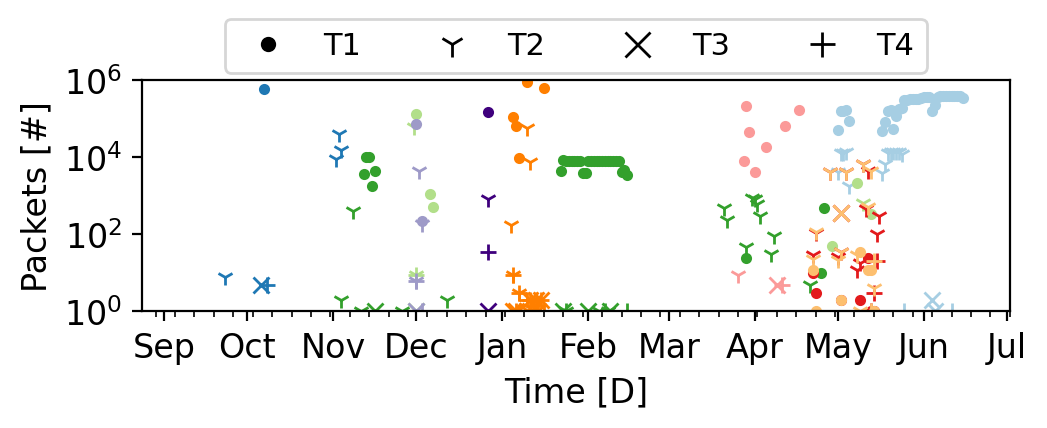

In [63]:
ax = None

for i, addr in enumerate(seen_by_all):
    print("addr: ", str(addr))
    ax = make_overlap_plot(filter_set=set([addr]), min_date=start_date, max_date=end_date, color=may_colors[i], ax=ax)
    # make_overlap_plot(filter_set=set([addr]), title=str(addr), min_date=start_date, max_date=end_date, color=tab_colors[i], ax=ax)

    msize = 9
    col = 'black'
    mfcol = 'black'
    legend_elements = [
        Line2D([0], [0], linestyle='', marker='.', color=col, label='T1', markerfacecolor=mfcol, markersize=msize),
        Line2D([0], [0], linestyle='', marker='1', color=col, label='T2', markerfacecolor=mfcol, markersize=msize),
        Line2D([0], [0], linestyle='', marker='x', color=col, label='T3', markerfacecolor=mfcol, markersize=msize),
        Line2D([0], [0], linestyle='', marker='+', color=col, label='T4', markerfacecolor=mfcol, markersize=msize),
    ]

    ax.legend(bbox_to_anchor=(0.5, 1.15), handles=legend_elements, loc='center', ncol=4, fontsize=11)

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

    ax.set_ylim([10**0, 10**6])

    # plt.savefig('plots/overlap-addrs-all-packets.pdf', bbox_inches='tight')


In [64]:
seen_by_all_ordered = [
    '2001:253:ff:4301:3673:79ff:fe91:48b8',
    '2001:550:9005:1000::11',
    '2001:550:9005:2000::11',
    '2001:da8:bf:300:ae1f:6bff:fefb:8b62',
    '2401:c080:1c00:2d8c:5400:4ff:feb3:fd43',
    '2401:c080:1c02:d91:5400:4ff:feaa:f563',
    '2602:ffd5:1:164::1',
    '2605:6400:10:6a8:bc7a:408:1ad:e7e6',
    '2a01:190:151a:1::5ba:100',
    '2a01:190:151a::5ba:100'
]

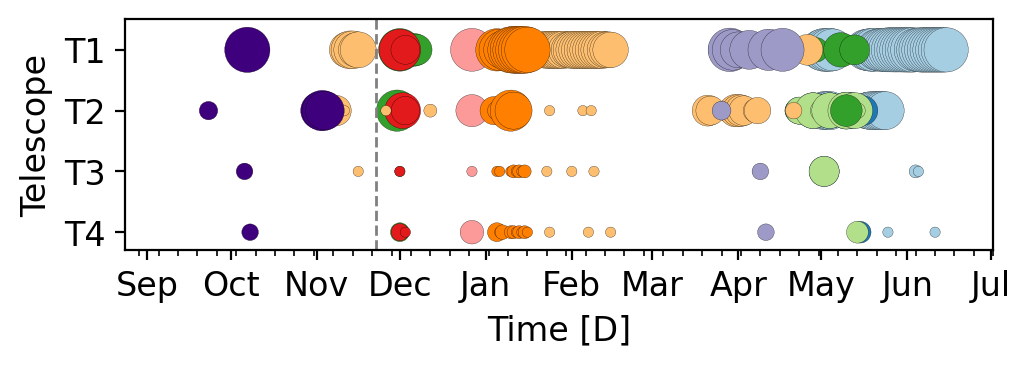

In [ ]:
plt.close()

min_date=start_date
max_date=end_date
title=None
color=None
ax=None

# -----

def log_scale_sizes(counts, scale=20):
    counts = np.array(counts)
    return scale * np.log1p(counts)  # log1p to avoid log(0)

def sqrt_scale_sizes(counts, scale=5):
    counts = np.array(counts)
    return scale * np.sqrt(counts)

def normalize_sizes(counts, min_size=10, max_size=100):
    counts = np.array(counts)
    norm = (counts - counts.min()) / (counts.max() - counts.min())
    return min_size + norm * (max_size - min_size)

def custom_scale_sizes(counts):
    counts = np.array(counts)
    return 50 / (1 + np.exp(-0.01 * (counts - 500)))  # sigmoid-like scaling


# -----

# filter_set = set([list(seen_by_all)[0]])

fig, ax = plt.subplots()

for pos, addr in enumerate(seen_by_all_ordered):

    filter_set = set([addr])

    def filter_all(df, name):
        return df.filter(pl.col("Source_Address").is_in(filter_set)).select(
            pl.col("Timestamp"),
            pl.col("Source_Address"),
            pl.col("Protocol"),
        ).with_columns(
            pl.col("Timestamp").dt.date().alias("Date"),
        ).group_by([pl.col("Date")]).agg(
            pl.col("Source_Address").count().alias(name)
        )

    overlap_t1 = filter_all(dft1, "T1")
    overlap_t2 = filter_all(dft2, "T2")
    overlap_t3 = filter_all(dft3, "T3")
    overlap_t4 = filter_all(dft4, "T4")
    sum_t1 = overlap_t1["T1"].sum()
    sum_t2 = overlap_t2["T2"].sum()
    sum_t3 = overlap_t3["T3"].sum()
    sum_t4 = overlap_t4["T4"].sum()

    total = sum_t1 + sum_t2 + sum_t3 + sum_t4

    # Create one df

    overlap_df = overlap_t1.join(overlap_t2, on="Date", how="full", coalesce=True)
    overlap_df = overlap_df.join(overlap_t3, on="Date", how="full", coalesce=True)
    overlap_df = overlap_df.join(overlap_t4, on="Date", how="full", coalesce=True)
    # overlap_df

    # Turn to pandas and reindex.
    plot_df = overlap_df.sort(pl.col("Date")).to_pandas()

    plot_df = plot_df.set_index("Date")
    range = pd.date_range(start=start_date, end=end_date, freq='D')
    plot_df = plot_df.reindex(index=range)

    telescopes = ["T1", "T2", "T3", "T4"]

    for i, scope in enumerate(telescopes):
        sizes = log_scale_sizes(plot_df[scope])
        # sizes = sqrt_scale_sizes(plot_df[scope])
        # sizes = custom_scale_sizes(plot_df[scope])
        xs = list(plot_df.index)
        ys = [i] * len(xs)

        ax.scatter(
            y=ys,
            x=xs,
            s=sizes,
            color=may_colors[pos],
            edgecolors='black',
            linewidths=0.1,
            # alpha=0.7,
        )

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

# ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax.yaxis.set_ticks([0, 1, 2, 3])
ax.yaxis.set_ticklabels(["T1", "T2", "T3", "T4"])

# ax.set_ylim([10**0, 10**6])

ax.set_xlim([start_date, end_date])
ax.set_ylim([-0.5, 3.3])

ax.axvline(vertical_dates[0], color="grey", linestyle="--", linewidth=1)

ax.set_ylabel("Telescope")
ax.set_xlabel("Time [D]")

plt.gca().invert_yaxis()

plt.savefig('plots/overlap-addrs-all-packets-by-telescope.pdf', bbox_inches='tight')


In [66]:
updated_order = [
    "2001:253:ff:4301:3673:79ff:fe91:48b8",   # 01
    "2001:550:9005:1000::11",                 # 02
    "2001:550:9005:2000::11",                 # 03
    "2001:da8:bf:300:ae1f:6bff:fefb:8b62",    # 04
    "2401:c080:1c00:2d8c:5400:4ff:feb3:fd43", # 05
    "2401:c080:1c02:d91:5400:4ff:feaa:f563",  # 06
    "2602:ffd5:1:164::1",                     # 07
    "2605:6400:10:6a8:bc7a:408:1ad:e7e6",     # 08
    "2a01:190:151a:1::5ba:100",               # 09
    "2a01:190:151a::5ba:100",                 # 10
]

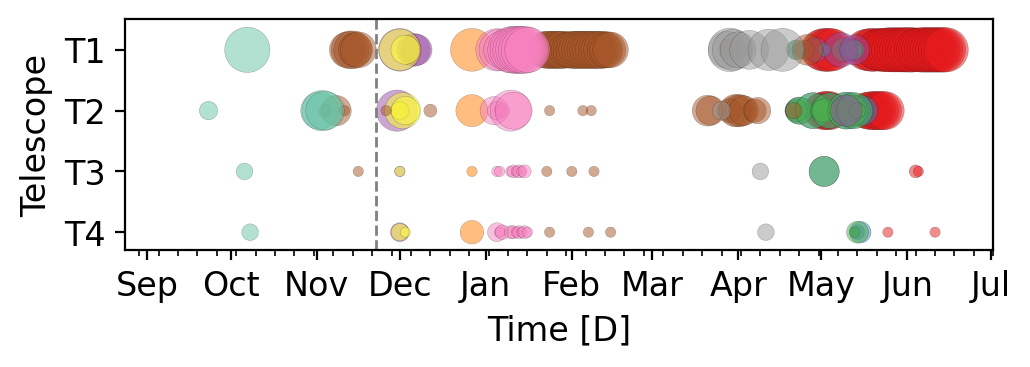

In [ ]:
## Figure 16a

plt.close()

min_date=start_date
max_date=end_date
title=None
color=None
ax=None

# -----

def log_scale_sizes(counts, scale=20):
    counts = np.array(counts)
    return scale * np.log1p(counts)  # log1p to avoid log(0)

def sqrt_scale_sizes(counts, scale=5):
    counts = np.array(counts)
    return scale * np.sqrt(counts)

def normalize_sizes(counts, min_size=10, max_size=100):
    counts = np.array(counts)
    norm = (counts - counts.min()) / (counts.max() - counts.min())
    return min_size + norm * (max_size - min_size)

def custom_scale_sizes(counts):
    counts = np.array(counts)
    return 50 / (1 + np.exp(-0.01 * (counts - 500)))  # sigmoid-like scaling


# -----

# filter_set = set([list(seen_by_all)[0]])

fig, ax = plt.subplots()

for pos, addr in enumerate(updated_order):

    filter_set = set([addr])

    def filter_all(df, name):
        return df.filter(pl.col("Source_Address").is_in(filter_set)).select(
            pl.col("Timestamp"),
            pl.col("Source_Address"),
            pl.col("Protocol"),
        ).with_columns(
            pl.col("Timestamp").dt.date().alias("Date"),
        ).group_by([pl.col("Date")]).agg(
            pl.col("Source_Address").count().alias(name)
        )

    overlap_t1 = filter_all(dft1, "T1")
    overlap_t2 = filter_all(dft2, "T2")
    overlap_t3 = filter_all(dft3, "T3")
    overlap_t4 = filter_all(dft4, "T4")
    sum_t1 = overlap_t1["T1"].sum()
    sum_t2 = overlap_t2["T2"].sum()
    sum_t3 = overlap_t3["T3"].sum()
    sum_t4 = overlap_t4["T4"].sum()

    total = sum_t1 + sum_t2 + sum_t3 + sum_t4

    # Create one df

    overlap_df = overlap_t1.join(overlap_t2, on="Date", how="full", coalesce=True)
    overlap_df = overlap_df.join(overlap_t3, on="Date", how="full", coalesce=True)
    overlap_df = overlap_df.join(overlap_t4, on="Date", how="full", coalesce=True)
    # overlap_df

    # Turn to pandas and reindex.
    plot_df = overlap_df.sort(pl.col("Date")).to_pandas()

    plot_df = plot_df.set_index("Date")
    range = pd.date_range(start=start_date, end=end_date, freq='D')
    plot_df = plot_df.reindex(index=range)

    telescopes = ["T1", "T2", "T3", "T4"]

    for i, scope in enumerate(telescopes):
        # sizes = [2**n for n in plot_df[scope]]
        # sizes = [sqrt(n) for n in plot_df[scope]]
        sizes = log_scale_sizes(plot_df[scope])
        # sizes = sqrt_scale_sizes(plot_df[scope])
        # sizes = custom_scale_sizes(plot_df[scope])
        xs = list(plot_df.index)
        ys = [i] * len(xs)

        ax.scatter(
            y=ys,
            x=xs,
            s=sizes,
            # color=may_colors[pos],
            color=chatgpt_colors[pos],
            # color=tab_colors[pos],
            edgecolors='black',
            linewidths=0.1,
            alpha=0.5,
        )

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

# ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
ax.yaxis.set_ticks([0, 1, 2, 3])
ax.yaxis.set_ticklabels(["T1", "T2", "T3", "T4"])

# ax.set_ylim([10**0, 10**6])

ax.set_xlim([start_date, end_date])
ax.set_ylim([-0.5, 3.3])

ax.axvline(vertical_dates[0], color="grey", linestyle="--", linewidth=1)

ax.set_ylabel("Telescope")
ax.set_xlabel("Time [D]")

plt.gca().invert_yaxis()

plt.savefig('plots/overlap-addrs-all-packets-by-telescope.pdf', bbox_inches='tight')


1 2001:253:ff:4301:3673:79ff:fe91:48b8
2 2001:550:9005:1000::11
3 2001:550:9005:2000::11
4 2001:da8:bf:300:ae1f:6bff:fefb:8b62
5 2401:c080:1c00:2d8c:5400:4ff:feb3:fd43
6 2401:c080:1c02:d91:5400:4ff:feaa:f563
7 2602:ffd5:1:164::1
8 2605:6400:10:6a8:bc7a:408:1ad:e7e6
9 2a01:190:151a:1::5ba:100
10 2a01:190:151a::5ba:100


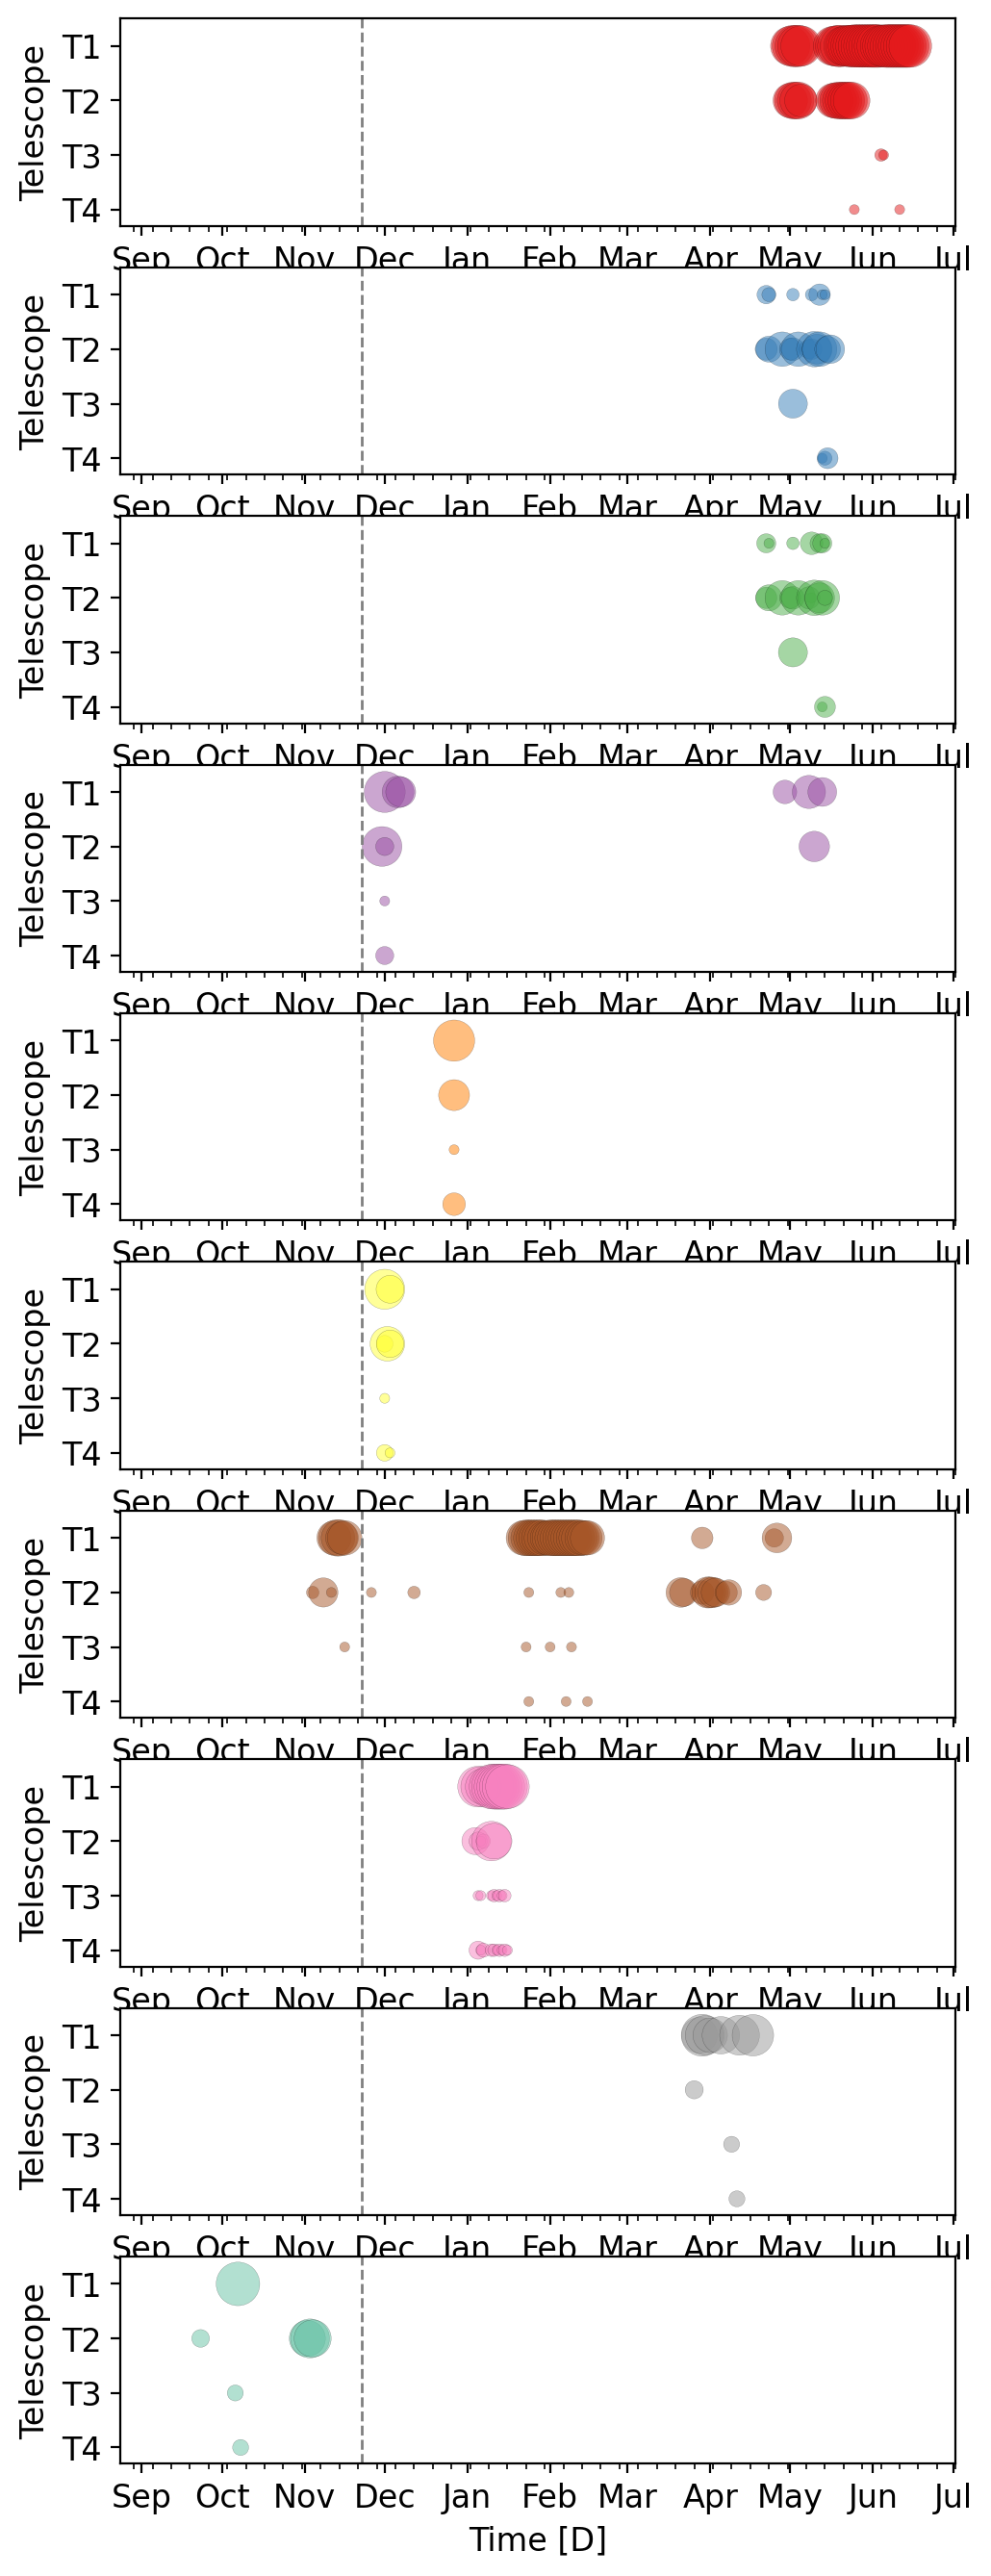

In [68]:
plt.close()

min_date=start_date
max_date=end_date
title=None
color=None
ax=None

# -----

def log_scale_sizes(counts, scale=20):
    counts = np.array(counts)
    return scale * np.log1p(counts)  # log1p to avoid log(0)

def sqrt_scale_sizes(counts, scale=5):
    counts = np.array(counts)
    return scale * np.sqrt(counts)

def normalize_sizes(counts, min_size=10, max_size=100):
    counts = np.array(counts)
    norm = (counts - counts.min()) / (counts.max() - counts.min())
    return min_size + norm * (max_size - min_size)

def custom_scale_sizes(counts):
    counts = np.array(counts)
    return 50 / (1 + np.exp(-0.01 * (counts - 500)))  # sigmoid-like scaling


# -----

# filter_set = set([list(seen_by_all)[0]])

fig, axes = plt.subplots(10, 1, figsize=(8 * 0.7, 3 * 0.5 * 11), sharex=False, sharey=False)
axes = axes.flatten()

for pos, addr in enumerate(updated_order):

    print((pos+1), addr)

    ax = axes[pos]

    filter_set = set([addr])

    def filter_all(df, name):
        return df.filter(pl.col("Source_Address").is_in(filter_set)).select(
            pl.col("Timestamp"),
            pl.col("Source_Address"),
            pl.col("Protocol"),
        ).with_columns(
            pl.col("Timestamp").dt.date().alias("Date"),
        ).group_by([pl.col("Date")]).agg(
            pl.col("Source_Address").count().alias(name)
        )

    overlap_t1 = filter_all(dft1, "T1")
    overlap_t2 = filter_all(dft2, "T2")
    overlap_t3 = filter_all(dft3, "T3")
    overlap_t4 = filter_all(dft4, "T4")
    sum_t1 = overlap_t1["T1"].sum()
    sum_t2 = overlap_t2["T2"].sum()
    sum_t3 = overlap_t3["T3"].sum()
    sum_t4 = overlap_t4["T4"].sum()

    total = sum_t1 + sum_t2 + sum_t3 + sum_t4

    # Create one df

    overlap_df = overlap_t1.join(overlap_t2, on="Date", how="full", coalesce=True)
    overlap_df = overlap_df.join(overlap_t3, on="Date", how="full", coalesce=True)
    overlap_df = overlap_df.join(overlap_t4, on="Date", how="full", coalesce=True)
    # overlap_df

    # Turn to pandas and reindex.
    plot_df = overlap_df.sort(pl.col("Date")).to_pandas()

    plot_df = plot_df.set_index("Date")
    range = pd.date_range(start=start_date, end=end_date, freq='D')
    plot_df = plot_df.reindex(index=range)

    telescopes = ["T1", "T2", "T3", "T4"]

    for i, scope in enumerate(telescopes):
        # sizes = [2**n for n in plot_df[scope]]
        # sizes = [sqrt(n) for n in plot_df[scope]]
        sizes = log_scale_sizes(plot_df[scope])
        # sizes = sqrt_scale_sizes(plot_df[scope])
        # sizes = custom_scale_sizes(plot_df[scope])
        xs = list(plot_df.index)
        ys = [i] * len(xs)

        ax.scatter(
            y=ys,
            x=xs,
            s=sizes,
            # color=may_colors[pos],
            color=chatgpt_colors[pos],
            edgecolors='black',
            linewidths=0.1,
            alpha=0.5,
        )

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_minor_locator(mdates.WeekdayLocator())

    # ax.yaxis.set_major_locator(mticker.MultipleLocator(1))
    ax.yaxis.set_ticks([0, 1, 2, 3])
    ax.yaxis.set_ticklabels(["T1", "T2", "T3", "T4"])

    # ax.set_ylim([10**0, 10**6])

    ax.set_xlim([start_date, end_date])
    ax.set_ylim([-0.5, 3.3])

    ax.axvline(vertical_dates[0], color="grey", linestyle="--", linewidth=1)

    ax.set_ylabel("Telescope")
    ax.set_xlabel("Time [D]")

    ax.invert_yaxis()

    # plt.show()

    # plt.gca().invert_yaxis()

plt.savefig('plots/overlap-addrs-all-packets-by-telescope-series.pdf', bbox_inches='tight')